# PSAW Data Extraction: 

In [127]:
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter, defaultdict
from psaw import PushshiftAPI
import datetime as dt
import matplotlib.pyplot as plt
from nltk.util import ngrams
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tokenizer import tokenizer
from datetime import datetime
import scipy.stats as sp
import csv, wikipedia, itertools, string, gensim, logging, sklearn, multiprocessing, re, pickle, json, nltk
import seaborn as sns
from scipy.stats import iqr
from pprint import pprint
from six import iteritems

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LassoCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics, model_selection
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error

In [4]:
#set for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Retrieve P-words: 

In [5]:
#retrieve Wikipedia drug names: 
drug_names = wikipedia.page("List of antidepressants")
drug_content = drug_names.content
drug_links = drug_names.links

In [6]:
drug_dict = {}
cur_cat = -1
for line in drug_content.split('\n')[1:]: 
    #to get categories 
    if line.startswith("=="): 
        cur_cat = line.strip(" == ")
        drug_dict[cur_cat] = dict()
    else: 
        if cur_cat != -1: 
            #extract the drug name using regex
            match = re.findall(r'([a-zA-Z]+) \(([^\)]+)\)', line)
            
            if len(match) > 0: 
                drug_dict[cur_cat][match[0][0]] = match[0][1].split(", ")


#manually delete false matches
false_matches = ['See also', 'References']
for false_match in false_matches: 
    del drug_dict[false_match]
print(drug_dict)

{'Selective serotonin reuptake inhibitors (SSRIs)': {'Citalopram': ['Celexa', 'Cipramil'], 'Escitalopram': ['Lexapro', 'Cipralex'], 'Fluoxetine': ['Prozac', 'Sarafem'], 'Fluvoxamine': ['Luvox', 'Faverin'], 'Paroxetine': ['Paxil', 'Seroxat'], 'Sertraline': ['Zoloft', 'Lustral']}, 'Serotonin–norepinephrine reuptake inhibitors (SNRIs)': {'Desvenlafaxine': ['Pristiq'], 'Duloxetine': ['Cymbalta'], 'Levomilnacipran': ['Fetzima'], 'Milnacipran': ['Ixel', 'Savella'], 'Venlafaxine': ['Effexor']}, 'Serotonin modulator and stimulators (SMSs)': {'Vilazodone': ['Viibryd'], 'Vortioxetine': ['Trintellix']}, 'Serotonin antagonist and reuptake inhibitors (SARIs)': {'Nefazodone': ['Dutonin', 'Nefadar', 'Serzone'], 'Trazodone': ['Desyrel']}, 'Norepinephrine reuptake inhibitors (NRIs)': {'Atomoxetine': ['Strattera'], 'Reboxetine': ['Edronax'], 'Teniloxazine': ['Lucelan', 'Metatone'], 'Viloxazine': ['Vivalan']}, 'Norepinephrine–dopamine reuptake inhibitors (NDRIs)': {'Bupropion': ['Wellbutrin']}, 'Tricycli

In [7]:
#generate lists of categories, generics, and brand names
categories = list(drug_dict.keys())
print("Categories length:", len(categories))
print(categories)

generics = [list(gen_dict.keys()) for gen_dict in drug_dict.values()]
generics = list(itertools.chain.from_iterable(generics))
print("Generics length:", len(generics))
print(generics)

brand_names = [list(gen_dict.values()) for gen_dict in drug_dict.values()]

#run the line below twice to unpack two levels
brand_names = list(itertools.chain.from_iterable(brand_names))
brand_names = list(itertools.chain.from_iterable(brand_names))
print("Brand names length:", len(brand_names))
print(brand_names)

Categories length: 22
['Selective serotonin reuptake inhibitors (SSRIs)', 'Serotonin–norepinephrine reuptake inhibitors (SNRIs)', 'Serotonin modulator and stimulators (SMSs)', 'Serotonin antagonist and reuptake inhibitors (SARIs)', 'Norepinephrine reuptake inhibitors (NRIs)', 'Norepinephrine–dopamine reuptake inhibitors (NDRIs)', 'Tricyclic antidepressants (TCAs)', 'Tetracyclic antidepressants (TeCAs)', 'Monoamine oxidase inhibitors (MAOIs)', 'Irreversible', 'Non-selective', 'Selective for MAO-B', 'Reversible', 'Selective for MAO-A', 'Mixed', 'Others', 'Marketed', 'Discontinued/withdrawn', 'Over-the-counter', 'Adjunctive treatments', 'Atypical antipsychotics', 'Combination products']
Generics length: 80
['Citalopram', 'Escitalopram', 'Fluoxetine', 'Fluvoxamine', 'Paroxetine', 'Sertraline', 'Desvenlafaxine', 'Duloxetine', 'Levomilnacipran', 'Milnacipran', 'Venlafaxine', 'Vilazodone', 'Vortioxetine', 'Nefazodone', 'Trazodone', 'Atomoxetine', 'Reboxetine', 'Teniloxazine', 'Viloxazine', 'B

In [8]:
# split up list of category names into abbreviations and full names: 
cat_no_abbrev = [x.split("(")[0] for x in categories]
print(cat_no_abbrev)

abbrev = [x for x in categories if len(x.split("(")) > 1]
cat_abbrev_pl = [x.split("(")[1].strip(")") for x in abbrev]
print(cat_abbrev_pl)

cat_abbrev_sing = [x.strip("s") for x in cat_abbrev_pl]
print(cat_abbrev_sing)

['Selective serotonin reuptake inhibitors ', 'Serotonin–norepinephrine reuptake inhibitors ', 'Serotonin modulator and stimulators ', 'Serotonin antagonist and reuptake inhibitors ', 'Norepinephrine reuptake inhibitors ', 'Norepinephrine–dopamine reuptake inhibitors ', 'Tricyclic antidepressants ', 'Tetracyclic antidepressants ', 'Monoamine oxidase inhibitors ', 'Irreversible', 'Non-selective', 'Selective for MAO-B', 'Reversible', 'Selective for MAO-A', 'Mixed', 'Others', 'Marketed', 'Discontinued/withdrawn', 'Over-the-counter', 'Adjunctive treatments', 'Atypical antipsychotics', 'Combination products']
['SSRIs', 'SNRIs', 'SMSs', 'SARIs', 'NRIs', 'NDRIs', 'TCAs', 'TeCAs', 'MAOIs']
['SSRI', 'SNRI', 'SMS', 'SARI', 'NRI', 'NDRI', 'TCA', 'TeCA', 'MAOI']


In [9]:
#generate list of lists of all words for later testing
all_words = [('generics', generics), ('brand_names', brand_names), ('cat_no_abbrev', cat_no_abbrev), ('cat_abbrev_pl', cat_abbrev_pl), ('cat_abbrev_sing', cat_abbrev_sing)]
print(all_words)

[('generics', ['Citalopram', 'Escitalopram', 'Fluoxetine', 'Fluvoxamine', 'Paroxetine', 'Sertraline', 'Desvenlafaxine', 'Duloxetine', 'Levomilnacipran', 'Milnacipran', 'Venlafaxine', 'Vilazodone', 'Vortioxetine', 'Nefazodone', 'Trazodone', 'Atomoxetine', 'Reboxetine', 'Teniloxazine', 'Viloxazine', 'Bupropion', 'Amitriptyline', 'Amitriptylinoxide', 'Clomipramine', 'Desipramine', 'Dibenzepin', 'Dimetacrine', 'Dosulepin', 'Doxepin', 'Imipramine', 'Lofepramine', 'Melitracen', 'Nitroxazepine', 'Nortriptyline', 'Noxiptiline', 'Opipramol', 'Pipofezine', 'Protriptyline', 'Trimipramine', 'Amoxapine', 'Maprotiline', 'Mianserin', 'Mirtazapine', 'Setiptiline', 'Bifemelane', 'Selegiline', 'Metralindole', 'Moclobemide', 'Pirlindole', 'Toloxatone', 'Eprobemide', 'Buspirone', 'Lithium', 'Thyroxine', 'Triiodothyronine', 'Agomelatine', 'Esketamine', 'Ketamine', 'Tandospirone', 'Tianeptine', 'agent', 'Ethyltryptamine', 'Indeloxazine', 'Medifoxamine', 'Oxaflozane', 'Pivagabine', 'methionine', 'Wort', 'Hyd

# Retrieve subreddit data: 

In [5]:
def GetSubreddit(subr, date): 
    api = PushshiftAPI()
    gen = api.search_comments(subreddit=subr, after=date)
    cache = []

    for c in gen:
        print('\'', end='')
        cache.append(c)

    # If you really want to: pick up where we left off to get the rest of the results.
    if False:
        for c in gen:
            cache.append(c)
            print('.', end='')
            
    comments = [post.d_ for post in cache]    
    df = pd.DataFrame(comments)
    return df

In [6]:
#start_epoch = int(datetime(2016, 1, 1).timestamp())
#antideps = GetSubreddit('space', start_epoch)

In [7]:
#opiates = GetSubreddit('opiates')

In [8]:
#antideps.to_pickle('a_pickle.pkl')
#antideps.to_pickle('space_pickle.pkl')
#opiates.to_pickle('o_pickle.pkl')

In [9]:
antideps = pd.read_pickle('a_pickle.pkl')
display(antideps.columns)
display(antideps.head())
display(antideps['link_id'].value_counts())
display(antideps[antideps['link_id'] == 't3_6tixvz'])
display(antideps['created_utc'])
#opiates = pd.read_pickle('o_pickle.pkl')

Index(['approved_at_utc', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_id', 'author_patreon_flair', 'body',
       'can_gild', 'collapsed', 'collapsed_reason', 'controversiality',
       'created', 'created_utc', 'distinguished', 'edited', 'gildings', 'id',
       'is_submitter', 'link_id', 'no_follow', 'parent_id', 'permalink',
       'removal_reason', 'retrieved_on', 'rte_mode', 'score', 'send_replies',
       'stickied', 'subreddit', 'subreddit_id'],
      dtype='object')

approved_at_utc                author author_cakeday  \
0              NaN           wifeofawife            NaN   
1              NaN          afraidofdust            NaN   
2              NaN  Dive_a_little_deeper            NaN   
3              NaN     newbieforever2016            NaN   
4              NaN             HiltonCGG            NaN   

  author_flair_background_color author_flair_css_class author_flair_richtext  \
0                          None                   None                    []   
1                          None                   None                    []   
2                          None                   None                    []   
3                                                 None                    []   
4                          None                   None                    []   

               author_flair_template_id author_flair_text  \
0                                  None              None   
1                                  None              None   
2                                  None              None   
3  b466c090-4a85-11e5-b2dd-0e8d84207ba5       Tetracyclic   
4                                  None              None   

  author_flair_text_color author_flair_type      ...        parent_id  \
0                    None              text      ...        t3_b5rprn   
1                    None              text      ...       t1_ejfzk3p   
2                    None              text      ...       t1_ejfhx3k   
3                    dark              text      ...       t1_ejfsp0b   
4                    None              text      ...       t1_ejflg8e   

                                           permalink removal_reason  \
0  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
1  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
2  /r/antidepressants/comments/b5ptg4/best_treatm...            NaN   
3  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
4  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   

   retrieved_on rte_mode score  send_replies  stickied        subreddit  \
0  1.553632e+09      NaN     1          True     False  antidepressants   
1  1.553632e+09      NaN     1          True     False  antidepressants   
2  1.553632e+09      NaN     1          True     False  antidepressants   
3  1.553632e+09      NaN     1          True     False  antidepressants   
4  1.553631e+09      NaN     1          True     False  antidepressants   

   subreddit_id  
0      t5_2szuo  
1      t5_2szuo  
2      t5_2szuo  
3      t5_2szuo  
4      t5_2szuo  

[5 rows x 37 columns]

t3_6tixvz    86
t3_aqoi1i    62
t3_850z4s    56
t3_9mhoe7    50
t3_ad3nbv    47
t3_6owd1g    46
t3_6pllzk    45
t3_aryqfy    40
t3_az0b8z    39
t3_adxmka    38
t3_axv10g    37
t3_9qark5    36
t3_92tlol    36
t3_at6auv    36
t3_aaphjb    35
t3_apoyzb    35
t3_9f1is9    34
t3_90bn7r    34
t3_apsgd0    34
t3_8q8rog    33
t3_afzz6i    33
t3_9dafhf    33
t3_aeqewp    33
t3_aihd9b    33
t3_a0r6ve    32
t3_a5r8bq    32
t3_ar091h    32
t3_6k0p8n    32
t3_9ib7et    32
t3_b01zd5    32
             ..
t3_782b5w     1
t3_53qem8     1
t3_64o5rl     1
t3_7d1tfa     1
t3_8n42l9     1
t3_b2jcx2     1
t3_aj2z36     1
t3_4km14w     1
t3_5y3inl     1
t3_4y8l23     1
t3_72ype4     1
t3_9pr2yp     1
t3_afor81     1
t3_9qaf5l     1
t3_7yt787     1
t3_al508s     1
t3_8yp4wz     1
t3_a64r5h     1
t3_6vvevs     1
t3_aj4akt     1
t3_b0qimd     1
t3_8u8uys     1
t3_74jhf7     1
t3_a1dis5     1
t3_4um8ho     1
t3_34auxw     1
t3_5pdu31     1
t3_5wdzmf     1
t3_6grn80     1
t3_655hn6     1
Name: link_id, Length: 5

approved_at_utc             author author_cakeday  \
28056              NaN  hyrulian_princess            NaN   
28058              NaN          PaulaRytt            NaN   
28059              NaN  hyrulian_princess            NaN   
28060              NaN          PaulaRytt            NaN   
28103              NaN  hyrulian_princess            NaN   
28104              NaN          vero94773            NaN   
28105              NaN  hyrulian_princess            NaN   
28106              NaN  hyrulian_princess            NaN   
28107              NaN          vero94773            NaN   
28108              NaN  hyrulian_princess            NaN   
28109              NaN          vero94773            NaN   
28110              NaN  hyrulian_princess            NaN   
28111              NaN          vero94773            NaN   
28112              NaN  hyrulian_princess            NaN   
28113              NaN          vero94773            NaN   
28114              NaN  hyrulian_princess            NaN   
28115              NaN          vero94773            NaN   
28116              NaN  hyrulian_princess            NaN   
28117              NaN          vero94773            NaN   
28120              NaN  hyrulian_princess            NaN   
28121              NaN          vero94773            NaN   
28122              NaN  hyrulian_princess            NaN   
28123              NaN          vero94773            NaN   
28127              NaN  hyrulian_princess            NaN   
28128              NaN          vero94773            NaN   
28129              NaN  hyrulian_princess            NaN   
28130              NaN  hyrulian_princess            NaN   
28131              NaN          vero94773            NaN   
28132              NaN  hyrulian_princess            NaN   
28133              NaN          vero94773            NaN   
...                ...                ...            ...   
28163              NaN  hyrulian_princess            NaN   
28172              NaN          vero94773            NaN   
28173              NaN  hyrulian_princess            NaN   
28174              NaN          vero94773            NaN   
28175              NaN  hyrulian_princess            NaN   
28176              NaN          vero94773            NaN   
28177              NaN  hyrulian_princess            NaN   
28178              NaN          vero94773            NaN   
28179              NaN  hyrulian_princess            NaN   
28180              NaN          vero94773            NaN   
28181              NaN  hyrulian_princess            NaN   
28182              NaN          vero94773            NaN   
28183              NaN  hyrulian_princess            NaN   
28185              NaN          vero94773            NaN   
28186              NaN  hyrulian_princess            NaN   
28187              NaN          vero94773            NaN   
28188              NaN  hyrulian_princess            NaN   
28189              NaN          vero94773            NaN   
28190              NaN  hyrulian_princess            NaN   
28191              NaN          vero94773            NaN   
28192              NaN  hyrulian_princess            NaN   
28193              NaN          vero94773            NaN   
28194              NaN  hyrulian_princess            NaN   
28195              NaN          vero94773            NaN   
28197              NaN  hyrulian_princess            NaN   
28199              NaN          vero94773            NaN   
28200              NaN  hyrulian_princess            NaN   
28201              NaN          vero94773            NaN   
28202              NaN  hyrulian_princess            NaN   
28204              NaN          vero94773            NaN   

      author_flair_background_color author_flair_css_class  \
28056                           NaN                   None   
28058                           NaN                   None   
28059                           NaN                   None   
28060                           NaN   

0        1553632374
1        1553631945
2        1553631591
3        1553631516
4        1553631267
5        1553631237
6        1553630935
7        1553629380
8        1553628532
9        1553628442
10       1553628055
11       1553627911
12       1553627806
13       1553627685
14       1553627560
15       1553627348
16       1553627088
17       1553627037
18       1553626400
19       1553626150
20       1553626055
21       1553625975
22       1553625310
23       1553625288
24       1553624802
25       1553624787
26       1553624577
27       1553624570
28       1553624341
29       1553624082
            ...    
31187    1319652545
31188    1319570942
31189    1319570371
31190    1319566552
31191    1319254525
31192    1319253756
31193    1319116094
31194    1319095851
31195    1319055411
31196    1319053057
31197    1319045414
31198    1319037734
31199    1319037319
31200    1319035794
31201    1319035788
31202    1319013191
31203    1319012917
31204    1319012549
31205    1319012320


In [10]:
first_100 = antideps.iloc[:100]
display(first_100['link_id'].value_counts())
display(first_100.head())
first_100.to_csv('first_100.csv')

t3_b5o0v9    17
t3_b5rprn    14
t3_b5ptg4    14
t3_b5pl13    11
t3_b5jxt5     5
t3_b5mrc6     5
t3_ay56te     4
t3_b5r44s     4
t3_b5tj0x     4
t3_b5t4zg     3
t3_b5nzur     3
t3_b5q2dw     2
t3_b5hf73     2
t3_b5ls6j     2
t3_b5nu2j     2
t3_b5rzi2     1
t3_b3f01m     1
t3_akju3a     1
t3_b2nl6t     1
t3_b59rjn     1
t3_b5fneu     1
t3_b5nqor     1
t3_b3q8u7     1
Name: link_id, dtype: int64

approved_at_utc                author author_cakeday  \
0              NaN           wifeofawife            NaN   
1              NaN          afraidofdust            NaN   
2              NaN  Dive_a_little_deeper            NaN   
3              NaN     newbieforever2016            NaN   
4              NaN             HiltonCGG            NaN   

  author_flair_background_color author_flair_css_class author_flair_richtext  \
0                          None                   None                    []   
1                          None                   None                    []   
2                          None                   None                    []   
3                                                 None                    []   
4                          None                   None                    []   

               author_flair_template_id author_flair_text  \
0                                  None              None   
1                                  None              None   
2                                  None              None   
3  b466c090-4a85-11e5-b2dd-0e8d84207ba5       Tetracyclic   
4                                  None              None   

  author_flair_text_color author_flair_type      ...        parent_id  \
0                    None              text      ...        t3_b5rprn   
1                    None              text      ...       t1_ejfzk3p   
2                    None              text      ...       t1_ejfhx3k   
3                    dark              text      ...       t1_ejfsp0b   
4                    None              text      ...       t1_ejflg8e   

                                           permalink removal_reason  \
0  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
1  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
2  /r/antidepressants/comments/b5ptg4/best_treatm...            NaN   
3  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   
4  /r/antidepressants/comments/b5rprn/im_sick_of_...            NaN   

   retrieved_on rte_mode score  send_replies  stickied        subreddit  \
0  1.553632e+09      NaN     1          True     False  antidepressants   
1  1.553632e+09      NaN     1          True     False  antidepressants   
2  1.553632e+09      NaN     1          True     False  antidepressants   
3  1.553632e+09      NaN     1          True     False  antidepressants   
4  1.553631e+09      NaN     1          True     False  antidepressants   

   subreddit_id  
0      t5_2szuo  
1      t5_2szuo  
2      t5_2szuo  
3      t5_2szuo  
4      t5_2szuo  

[5 rows x 37 columns]

In [11]:
pd.set_option('display.max_colwidth', -1)
reduced = antideps.filter(['author', 'body', 'link_id', 'parent_id', 'permalink'])
display(reduced[reduced['link_id'] == 't3_b5rprn'])
display(reduced['permalink'].head())

author  \
0   wifeofawife         
1   afraidofdust        
3   newbieforever2016   
4   HiltonCGG           
5   HiltonCGG           
6   littlemoonwitch     
10  Quailpower          
16  afraidofdust        
17  drugzpix            
31  afraidofdust        
32  rowinghippy         
36  CSThr0waway123      
37  afraidofdust        
38  CSThr0waway123      

                                                                                                                                                                                                                                                                                          body  \
0   Literally what I’m crying about right now. I wish I had never started                                                                                                                                                                                                                        
1   I've been on both so maybe there is hope for me. But oh my god. Why am I taking these awful pills that are ruining my body, oh my god. I am so down about it right now.                                                                                                                      
3   Thriced!  Totally sent my insomnia packing.                                                                                                                                                                                                                                                  
4   Same for me, but about two years later my sex drive still wasn’t back. Bupropion is helping me a little bit though.                                                                                                                                                                          
5   I got off citalopram for this exact reason and coming off it was hell. But my sex drive was non existent. I was on it twice and I never gained my sex drive back until I started Bupropion recently (almost 2 years since I quit citalopram), it’s slowly improving, but still not great.    
6   Some people take Wellbutrin in addition to whatever else they’re taking. Apparently it can increase sex drive in some patients\n\nKeep in mind that it can also increase anxiety                                                                                                             
10  Seconding this, amazing sleep.                                                                                                                                                                                                                                                               
16  I'll research it, thanks.                                                                                                                                                                                                                                                                    
17  Try mirtazapine, doesn’t kill your sex drive and you get amazing sleep                                                                                                                                                                                                                       
31  Yeah maybe last time I went too fast. Are you talking like, over the course of months instead of weeks?                                                                                                                                                                                      
32  You can try to get off citalopram again, but at a slower rate this time around. Yeah, it sucks that if it ends up taking a while, but it's better than just staying on as planned if it continues to negatively impact you.                                                                  
36  Yup. Might just be temporary, but at this point I really don't even care anymore. I get erections maybe like once or twice a week now.                     

0    /r/antidepressants/comments/b5rprn/im_sick_of_pills/ejg1duz/       
1    /r/antidepressants/comments/b5rprn/im_sick_of_pills/ejg0p42/       
2    /r/antidepressants/comments/b5ptg4/best_treatment_for_ptsd/ejg04nr/
3    /r/antidepressants/comments/b5rprn/im_sick_of_pills/ejg0055/       
4    /r/antidepressants/comments/b5rprn/im_sick_of_pills/ejfzlvm/       
Name: permalink, dtype: object

# Data cleaning: 

In [12]:
display(antideps.columns)

Index(['approved_at_utc', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_id', 'author_patreon_flair', 'body',
       'can_gild', 'collapsed', 'collapsed_reason', 'controversiality',
       'created', 'created_utc', 'distinguished', 'edited', 'gildings', 'id',
       'is_submitter', 'link_id', 'no_follow', 'parent_id', 'permalink',
       'removal_reason', 'retrieved_on', 'rte_mode', 'score', 'send_replies',
       'stickied', 'subreddit', 'subreddit_id'],
      dtype='object')

In [13]:
#remove posts by known bots
bots_path = '/Users/benjamingittelson/Documents/SDS/Hillary Term/NLP/Summative/nonstandard_word_dissemination/data/metadata/bots.txt'
with open(bots_path) as file: 
    bots = set(file.read().split())

antideps['bot'] = antideps['author'].map(lambda x: x in bots)

display(antideps.shape)
drop_bots = antideps[antideps['bot'] == False]
display(drop_bots.shape)

#remove posts by known spammers
spammers_path = '/Users/benjamingittelson/Documents/SDS/Hillary Term/NLP/Summative/nonstandard_word_dissemination/data/metadata/spammers.txt'
with open(spammers_path) as file: 
    spammers = set(file.read().split())


drop_bots['spammer'] = drop_bots['author'].map(lambda x: x in spammers)
drop_spammers = drop_bots[drop_bots['spammer'] == False]
display(drop_spammers.shape)

(31217, 38)

(31215, 38)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(31215, 39)

In [14]:
#remove duplicate text and lowercase all text
no_dups = drop_spammers.drop_duplicates(subset='body')
no_dups['body_uncleaned'] = no_dups['body']

#remove punction and lowercase all text
no_dups['body'] = no_dups['body'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

display(no_dups['body'].head())
display(no_dups['body_uncleaned'].head())

display(no_dups.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    literally what i’m crying about right now i wish i had never started                                                                                             
1    ive been on both so maybe there is hope for me but oh my god why am i taking these awful pills that are ruining my body oh my god i am so down about it right now
2    amen                                                                                                                                                             
3    thriced  totally sent my insomnia packing                                                                                                                        
4    same for me but about two years later my sex drive still wasn’t back bupropion is helping me a little bit though                                                 
Name: body, dtype: object

0    Literally what I’m crying about right now. I wish I had never started                                                                                                  
1    I've been on both so maybe there is hope for me. But oh my god. Why am I taking these awful pills that are ruining my body, oh my god. I am so down about it right now.
2    Amen                                                                                                                                                                   
3    Thriced!  Totally sent my insomnia packing.                                                                                                                            
4    Same for me, but about two years later my sex drive still wasn’t back. Bupropion is helping me a little bit though.                                                    
Name: body_uncleaned, dtype: object

(30613, 40)

In [15]:
#tokenize using reddit tokenizer: https://github.com/erikavaris/tokenizer?
#strip out links
no_dups['no_links'] = no_dups['body'].map(lambda x: re.sub(r'http\S+', 'LINK', x))
display(no_dups['no_links'].head())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    literally what i’m crying about right now i wish i had never started                                                                                             
1    ive been on both so maybe there is hope for me but oh my god why am i taking these awful pills that are ruining my body oh my god i am so down about it right now
2    amen                                                                                                                                                             
3    thriced  totally sent my insomnia packing                                                                                                                        
4    same for me but about two years later my sex drive still wasn’t back bupropion is helping me a little bit though                                                 
Name: no_links, dtype: object

# LSA Test: 

In [16]:
#get corpus
lsa_corpus = no_dups['body'].tolist()

#write to .txt file, 
with open('lsa_corpus.txt', 'w') as file: 
    for line in lsa_corpus: 
        file.write(line)
        file.write('\n')

print(lsa_corpus[:10])

['literally what i’m crying about right now i wish i had never started ', 'ive been on both so maybe there is hope for me but oh my god why am i taking these awful pills that are ruining my body oh my god i am so down about it right now', 'amen', 'thriced  totally sent my insomnia packing', 'same for me but about two years later my sex drive still wasn’t back bupropion is helping me a little bit though ', 'i got off citalopram for this exact reason and coming off it was hell but my sex drive was non existent i was on it twice and i never gained my sex drive back until i started bupropion recently almost 2 years since i quit citalopram it’s slowly improving but still not great ', 'some people take wellbutrin in addition to whatever else they’re taking apparently it can increase sex drive in some patients\n\nkeep in mind that it can also increase anxiety', 'good luck', 'i tried trazodone which gave me a horrendous case of dry mouth truly intolerable other than that i tried benadryl and v

## Define corpus class: 

In [17]:
class MyCorpus(object): 
    def __init__(self, my_corpus, my_dict): 
        self.corpus = my_corpus
        self.dictionary = my_dict
    
    def __iter__(self): 
        for line in open(self.corpus): 
            yield self.dictionary.doc2bow(line.lower().split())

## Make memory-friendly dict representation: 

In [18]:
lsa_dict = gensim.corpora.Dictionary(line.lower().split() for line in open('lsa_corpus.txt'))

#filter stop words
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_ids = [lsa_dict.token2id[stopword] for stopword in stop_words if stopword in lsa_dict.token2id]

#filter hapaxes
hapax_ids = [tokenid for tokenid, docfreq in iteritems(lsa_dict.dfs) if docfreq == 1]

#remove stops
lsa_dict.filter_tokens(stop_ids + hapax_ids)

#make ids sequential again
lsa_dict.compactify()

#sanity check
print(lsa_dict)

2019-05-15 11:40:00,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-05-15 11:40:01,491 : INFO : adding document #10000 to Dictionary(10916 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:02,167 : INFO : adding document #20000 to Dictionary(15726 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:02,867 : INFO : adding document #30000 to Dictionary(19432 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:03,530 : INFO : adding document #40000 to Dictionary(22726 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:04,120 : INFO : adding document #50000 to Dictionary(25841 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:04,774 : INFO : adding document #60000 to Dictionary(28700 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']...)
2019-05-15 11:40:05,099 : INFO : built Dictionary(29783 unique tokens: ['about', 'crying', 'had', 'i', 'i’m']

Dictionary(13791 unique tokens: ['crying', 'i’m', 'literally', 'never', 'right']...)


## Read in memory-friendly corpus representation and run LSA: 

In [19]:
#read in text file
mem_corpus = MyCorpus('lsa_corpus.txt', lsa_dict)
print(list(mem_corpus)[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(4, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1)], [(17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1)], [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(3, 1), (5, 1), (22, 1), (24, 1), (25, 2), (29, 2), (30, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(16, 1), (25, 1), (29, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [], [(57, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(68, 1), (69, 1)]]


In [20]:
#tfidf transformation 
tfidf = gensim.models.TfidfModel(mem_corpus)
corpus_tfidf = tfidf[mem_corpus]

2019-05-15 11:40:13,164 : INFO : collecting document frequencies
2019-05-15 11:40:13,166 : INFO : PROGRESS: processing document #0
2019-05-15 11:40:13,589 : INFO : PROGRESS: processing document #10000
2019-05-15 11:40:14,099 : INFO : PROGRESS: processing document #20000
2019-05-15 11:40:14,642 : INFO : PROGRESS: processing document #30000
2019-05-15 11:40:15,107 : INFO : PROGRESS: processing document #40000
2019-05-15 11:40:15,543 : INFO : PROGRESS: processing document #50000
2019-05-15 11:40:15,992 : INFO : PROGRESS: processing document #60000
2019-05-15 11:40:16,183 : INFO : calculating IDF weights for 63641 documents and 13790 features (771156 matrix non-zeros)


In [21]:
#run lsi/a on corpus
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=lsa_dict, num_topics=4)
corpus_lsi = lsi[corpus_tfidf]

2019-05-15 11:40:18,173 : INFO : using serial LSI version on this node
2019-05-15 11:40:18,176 : INFO : updating model with new documents
2019-05-15 11:40:21,915 : INFO : preparing a new chunk of documents
2019-05-15 11:40:22,101 : INFO : using 100 extra samples and 2 power iterations
2019-05-15 11:40:22,102 : INFO : 1st phase: constructing (13791, 104) action matrix
2019-05-15 11:40:22,316 : INFO : orthonormalizing (13791, 104) action matrix
2019-05-15 11:40:23,525 : INFO : 2nd phase: running dense svd on (104, 20000) matrix
2019-05-15 11:40:24,722 : INFO : computing the final decomposition
2019-05-15 11:40:24,726 : INFO : keeping 4 factors (discarding 78.841% of energy spectrum)
2019-05-15 11:40:25,392 : INFO : processed documents up to #20000
2019-05-15 11:40:25,411 : INFO : topic #0(17.205): -1.000*"ampx200b" + -0.000*"went" + -0.000*"could" + -0.000*"prozac" + -0.000*"depression" + 0.000*"sleep" + 0.000*"withdrawals" + -0.000*"i’m" + 0.000*"hey" + -0.000*"week"
2019-05-15 11:40:25

In [22]:
lsi.print_topics()

2019-05-15 11:40:49,860 : INFO : topic #0(26.117): 0.150*"im" + 0.149*"side" + 0.149*"effects" + 0.148*"like" + 0.144*"feel" + 0.133*"take" + 0.123*"time" + 0.123*"taking" + 0.121*"get" + 0.120*"anxiety"
2019-05-15 11:40:49,863 : INFO : topic #1(21.840): -1.000*"ampx200b" + -0.000*"talk" + 0.000*"also" + 0.000*"see" + -0.000*"get" + -0.000*"depression" + -0.000*"20mg" + -0.000*"soon" + 0.000*"anything" + 0.000*"two"
2019-05-15 11:40:49,866 : INFO : topic #2(15.759): -0.686*"luck" + -0.599*"good" + -0.211*"thank" + -0.140*"best" + -0.133*"hope" + -0.127*"thanks" + 0.074*"side" + 0.073*"effects" + 0.048*"taking" + -0.047*"helps"
2019-05-15 11:40:49,868 : INFO : topic #3(12.010): -0.751*"thank" + -0.318*"hope" + 0.251*"luck" + -0.246*"thanks" + -0.243*"helps" + 0.203*"good" + -0.138*"much" + 0.098*"side" + 0.096*"effects" + -0.066*"reply"


[(0,
  '0.150*"im" + 0.149*"side" + 0.149*"effects" + 0.148*"like" + 0.144*"feel" + 0.133*"take" + 0.123*"time" + 0.123*"taking" + 0.121*"get" + 0.120*"anxiety"'),
 (1,
  '-1.000*"ampx200b" + -0.000*"talk" + 0.000*"also" + 0.000*"see" + -0.000*"get" + -0.000*"depression" + -0.000*"20mg" + -0.000*"soon" + 0.000*"anything" + 0.000*"two"'),
 (2,
  '-0.686*"luck" + -0.599*"good" + -0.211*"thank" + -0.140*"best" + -0.133*"hope" + -0.127*"thanks" + 0.074*"side" + 0.073*"effects" + 0.048*"taking" + -0.047*"helps"'),
 (3,
  '-0.751*"thank" + -0.318*"hope" + 0.251*"luck" + -0.246*"thanks" + -0.243*"helps" + 0.203*"good" + -0.138*"much" + 0.098*"side" + 0.096*"effects" + -0.066*"reply"')]

# Corpus summary statistics: 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


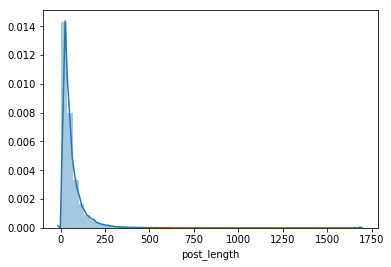

In [23]:
no_dups['post_length'] = no_dups['body'].map(lambda x: len(x.split()))
sns.distplot(no_dups['post_length'])

In [24]:
print("Number of posts:", no_dups.shape[0])
print("Number of users:", no_dups['author'].nunique())
print("Number of threads:", no_dups['parent_id'].nunique())
print("Median post length:", no_dups['post_length'].median())
print("Total number of tokens:", no_dups['post_length'].sum())

Number of posts: 30613
Number of users: 5095
Number of threads: 18876
Median post length: 35.0
Total number of tokens: 1665810


# Social dissemination functions: 

In [25]:
def TimeSubset(start, end, df): 
    subset = df[(df['created_utc'] >= start) & (df['created_utc'] <= end)].copy()
    return subset

def TimeSubsetPosts(start, end, df): 
    subset_posts = list(df[(df['created_utc'] >= start) & (df['created_utc'] <= end)].copy()['body'])
    return subset_posts


sub = TimeSubset(1319008914, 1719008914, no_dups)
sub_posts = TimeSubsetPosts(1319008914, 1719008914, no_dups)

In [26]:
#loop over users
#for each user, create a sub-dataframe
#check if that user's posts include the word in question

def getU_w(word, texts): 
    U_w = 0
    for user in texts['author'].values:
        user_sub = texts[texts['author'] == user]['body'].tolist()
        user_set = set(' '.join(user_sub).split())
        if word in user_set: 
            U_w += 1
    return U_w
        
def getU_w_exp(word, texts, vocab): 
    pass

def makeVocab(sub_df, cutoff=0): 
    texts = ' '.join(sub_df['body'].tolist())
    t_tizer = tokenizer.RedditTokenizer(preserve_handles=False, preserve_case=False, preserve_url=False)
    tokens = t_tizer.tokenize(texts)
    vocab = Counter(tokens)
    
    #filter out words below a frequency cutoff, following Altmann et al. 2011
    if cutoff > 0: 
        trimmed_vocab = Counter(el for el in vocab.elements() if vocab[el] > cutoff)
        return trimmed_vocab
    return vocab

#adapted from formative model answers
def getf_w(word, vocab):
    return vocab[word]/sum(vocab.values())

#adapted from formative model answers
def getE_w(f_w, word, texts, vocab):
    E_w = 0
    
    #instead of iterating over posts, iterate over all texts by  given user
    for user in texts['author'].values: 
        user_sub = texts[texts['author'] == user]['body'].tolist()
        E_w += (1 - np.exp(-f_w*len(user_sub)))
    return E_w

# print(getU_w('the', sub))
test_voc = makeVocab(sub, 5)
print(test_voc.most_common())
# f_w_prozac = getf_w('the', vocab)
# print('f_w_the:', f_w_prozac)
# E_w_prozac = getE_w(f_w_prozac, 'the', sub, vocab)
# print("E_w_the:", E_w_prozac)

[('i', 65371), ('to', 46701), ('the', 46437), ('and', 41308), ('it', 37575), ('a', 36113), ('you', 31142), ('of', 24486), ('for', 22912), ('that', 20755), ('is', 18098), ('my', 17358), ('on', 17140), ('but', 16364), ('’', 15757), ('in', 15573), ('have', 12792), ('with', 12382), ('was', 12144), ('me', 11852), ('your', 11445), ('if', 11302), ('not', 10792), ('be', 10642), ('so', 10401), ('this', 9294), ('as', 8896), ('or', 8356), ('are', 8276), ('just', 8118), ('can', 7912), ('its', 7693), ('like', 7577), ('at', 6961), ('im', 6667), ('about', 6630), ('been', 5959), ('effects', 5709), ('feel', 5574), ('had', 5563), ('side', 5493), ('get', 5386), ('do', 5338), ('more', 5267), ('take', 5219), ('time', 5125), ('they', 5080), ('off', 5078), ('from', 5050), ('what', 5010), ('when', 4936), ('will', 4665), ('t', 4659), ('all', 4628), ('anxiety', 4621), ('would', 4617), ('really', 4598), ('an', 4587), ('some', 4549), ('taking', 4494), ('up', 4461), ('out', 4426), ('dont', 4373), ('also', 4345), (

In [27]:
#dissemination across users, all in one function: 
def getD_U(word, texts, vocab): 
    #calculate numerator (U_w)
    num = 0
    
    user_posts = []
    
    #get the user sub and append to the list in one pass
    for user in texts['author'].unique():
        user_list = texts[texts['author'] == user]['body'].tolist()
        user_sub = ' '.join(user_list).split()
        user_posts.append(user_sub)
        user_set = set(' '.join(user_sub).split())
        if word in user_set: 
            num += 1
            #print(num)
    
    #calculate f_w
    try: 
        f_w = vocab[word]/sum(vocab.values())
    except ZeroDivisionError as zdiv: 
        print(zdiv)
        return np.nan
    
    #calculate e_w
    denom = 0
    
    #instead of iterating over posts, iterate over all texts by  given user
    for combined_posts in user_posts:
        denom += (1 - np.exp(-f_w*len(combined_posts)))
    
    return num/denom

In [24]:
test = getD_U('celexa', no_dups, test_voc)
print(test)

0.6264502235288045


In [25]:
#essentially the same calculation as with D_U, except that you check posts that have the same parent id
def getD_T(word, texts, vocab): 
    #calculate numerator (U_w)
    num = 0
    
    thread_posts = []
    
    #get the thread sub and append to the list in one pass
    for thread in texts['parent_id'].unique():
        thread_list = texts[texts['parent_id'] == thread]['body'].tolist()
        thread_sub = ' '.join(thread_list).split()
        thread_posts.append(thread_sub)
        thread_set = set(' '.join(thread_sub).split())
        if word in thread_set: 
            num += 1
    
    #calculate f_w
    try: 
        f_w = vocab[word]/sum(vocab.values())
    except ZeroDivisionError as zdiv: 
        print(zdiv)
        return np.nan
    
    #calculate e_w
    denom = 0
    
    #instead of iterating over posts, iterate over all texts by  given thread
    for combined_posts in thread_posts:
        denom += (1 - np.exp(-f_w*len(combined_posts)))
    
    return num/denom

In [26]:
d_t_test = getD_T('the', no_dups, test_voc)
print(d_t_test)

0.9850045093833043


In [27]:
#read in prefixes and suffixes used in Kershaw et al. (2016)
suffix_path = '/Users/CANDIDATENAME/Documents/SDS/Hillary Term/NLP/Summative/en_suffix.csv'
with open(suffix_path, 'r') as file: 
    suffixes = []
    reader = csv.reader(file)
    for row in reader:
        suffixes.append(row[0])

print(suffixes)

prefix_path = '/Users/CANDIDATENAME/Documents/SDS/Hillary Term/NLP/Summative/en_prefix.csv'
with open(prefix_path, 'r') as file: 
    prefixes = []
    reader = csv.reader(file)
    for row in reader:
        prefixes.append(row[0])

print(prefixes)

['able', 'ible', 'al', 'ial', 'ed', 'en', 'er', 'est', 'ful', 'ic', 'ing', 'ion', 'tion', 'ation', 'ition', 'ity', 'ty', 'ive', 'ative', 'itive', 'less', 'ly', 'ment', 'ness', 'ous', 'eous', 'ious', 's', 'es', 'y']
['a', 'an', 'ante', 'anti', 'auto', 'circum', 'co', 'com', 'con', 'contra', 'de', 'dis', 'en', 'ex', 'extra', 'hetro', 'homo', 'hyper', 'li', 'im', 'in', 'ir', 'in', 'inter', 'intra', 'macro', 'mono', 'non', 'omni', 'post', 'pre', 'pro', 'sub', 'syn', 'trans', 'tri', 'un', 'uni']


In [28]:
#dissemination across prefixes
def getD_P(word, texts, vocab, pref): 
    num = 0
    for prefix in pref: 
        cur_word = prefix + word
        if cur_word in vocab.keys(): 
            #Kershaw: for each an occurrence of the word + the prefix, add 1
            #here, can just take the count since we've already counted
            num += vocab[cur_word]
            
        #also check with dash
        cur_dash = prefix + '-' + word
        if cur_dash in vocab.keys(): 
            num += vocab[cur_dash]
  
    #denominator = size of the corpus at time t
    denom = sum(vocab.values())
    if denom > 0: 
        return num/denom
    
    else:
        return np.nan

In [29]:
#test with a few words as a sanity check
getD_P('sexual', no_dups, test_voc, prefixes)
#make sure that values are probabilities, i.e. between 0 and 1

4.802676051095671e-06

In [30]:
def getD_S(word, texts, vocab, suff): 
    num = 0
    for suffix in suff: 
        cur_word = word + suffix
        if cur_word in vocab.keys(): 
            #Kershaw: for each an occurrence of the word + the prefix, add 1
            #here, can just take the count since we've already counted
            num += vocab[cur_word]

            
        #also check with dash
        cur_dash = word + '-' + suffix
        if cur_dash in vocab.keys(): 
            num += vocab[cur_dash]

        
        

        
    #denominator = size of the corpus at time t
    denom = sum(vocab.values())
    if denom > 0: 
        return num/denom
    
    else:
        return np.nan

In [31]:
d_s = getD_S('sad', no_dups, test_voc, suffixes)
print(d_s)

7.924415484307856e-05


# Linguistic dissemination functions: 

In [33]:
#calculate trigrams from vocabulary of posts
def getD_L(texts, n): 
    #join all texts together
    joined = ' '.join(texts['body'].tolist())
    
    #generate n-grams from text
    tizer = tokenizer.RedditTokenizer(preserve_case=False)
    tokens = tizer.tokenize(joined)
    n_grams = list(ngrams(tokens, n))
    vocab = Counter(tokens)
    
    #calculate number of n-grams in which each word appears and add as column to pandas df
    df = pd.DataFrame()
    df['word'] = vocab.keys()
    df['freq'] = df['word'].map(lambda x: vocab[x])
    df['log_freq'] = df['freq'].map(lambda x: np.log(x))
    df['n_grams'] = df['word'].map(lambda x: len(set([y for y in n_grams if x in y])))
    df['log_n_grams'] = df['n_grams'].map(lambda x: np.log(x))
    
    #use statsmodels to calculate linear regression, using smf so you don't have to add a constant
    reg = smf.ols('np.log(n_grams) ~ np.log(freq)', data=df).fit()
    
    #predict values for each word: 
    predictions = reg.predict(df['freq'])
    df['pred'] = predictions
    df['D_L'] = df.apply(lambda x: x['log_n_grams'] - x['pred'], axis=1)

    return df

In [34]:
#for testing, generate a random sample from the df
random_test = no_dups.sample(200, random_state=1)
getD_L(random_test, 3)

word  freq  log_freq  n_grams  log_n_grams      pred       D_L
0     i            410   6.016157  1077     6.981935     7.009836 -0.027902
1     gotta        1     0.000000  2        0.693147     1.097102 -0.403955
2     say          7     1.945910  20       2.995732     3.009560 -0.013828
3     the          253   5.533389  723      6.583409     6.535368  0.048041
4     biggest      2     0.693147  6        1.791759     1.778333  0.013426
5     side         30    3.401197  88       4.477337     4.439830  0.037507
6     effect       20    2.995732  60       4.094345     4.041335  0.053010
7     received     1     0.000000  3        1.098612     1.097102  0.001510
8     from         28    3.332205  84       4.430817     4.372023  0.058794
9     paxil        8     2.079442  23       3.135494     3.140796 -0.005302
10    20mg         3     1.098612  9        2.197225     2.176828  0.020396
11    was          77    4.343805  209      5.342334     5.366234 -0.023899
12    sexual       4     1.386294  12       2.484907     2.459565  0.025342
13    disfuction   1     0.000000  3        1.098612     1.097102  0.001510
14    like         42    3.737670  120      4.787492     4.770518  0.016974
15    to           298   5.697093  830      6.721426     6.696258  0.025168
16    call         4     1.386294  12       2.484907     2.459565  0.025342
17    this         58    4.060443  174      5.159055     5.087742  0.071313
18    paxildick    1     0.000000  3        1.098612     1.097102  0.001510
19    because      30    3.401197  89       4.488636     4.439830  0.048807
20    you          192   5.257495  523      6.259581     6.264216 -0.004635
21    can          48    3.871201  137      4.919981     4.901754  0.018227
22    easily       2     0.693147  5        1.609438     1.778333 -0.168895
23    get          44    3.784190  124      4.820282     4.816238  0.004043
24    an           27    3.295837  79       4.369448     4.336281  0.033167
25    erection     1     0.000000  3        1.098612     1.097102  0.001510
26    but          90    4.499810  257      5.549076     5.519556  0.029520
27    reaching     1     0.000000  3        1.098612     1.097102  0.001510
28    orgasm       2     0.693147  6        1.791759     1.778333  0.013426
29    is           118   4.770685  346      5.846439     5.785774  0.060664
...   ..           ...        ...  ...           ...          ...       ...
1817  startimg     1     0.000000  3        1.098612     1.097102  0.001510
1818  doxal        2     0.693147  6        1.791759     1.778333  0.013426
1819  dropping     1     0.000000  3        1.098612     1.097102  0.001510
1820  grogginess   1     0.000000  3        1.098612     1.097102  0.001510
1821  notable      1     0.000000  3        1.098612     1.097102  0.001510
1822  bigger       1     0.000000  3        1.098612     1.097102  0.001510
1823  acv          1     0.000000  3        1.098612     1.097102  0.001510
1824  hands        1     0.000000  3        1.098612     1.097102  0.001510
1825  disappeared  2     0.693147  6        1.791759     1.778333  0.013426
1826  24           2     0.693147  6        1.791759     1.778333  0.013426
1827  starts       1     0.000000  3        1.098612     1.097102  0.001510
1828  levelling    1     0.000000  3        1.098612     1.097102  0.001510
1829  main         1     0.000000  3        1.098612     1.097102  0.001510
1830  dry          1     0.000000  3        1.098612     1.097102  0.001510
1831  tiredness    1     0.000000  3        1.098612     1.097102  0.001510
1832  sweating     1     0.000000  3        1.098612     1.097102  0.001510
1833  difficulty   1     0.000000  3        1.098612     1.097102  0.001510
1834  resolved     1     0.000000  3        1.098612     1.097102  0.001510
1835  aside        1     0.000000  3        1.098612     1.097102  0.001510
1836  3rd          1     0.000000  3        1.098612     1.097102  0.001510
1837  sudden       1     0.000000  3        1.098612     1.09

# Extracting and plotting word frequencies: 

In [35]:
def PlotFreq(word, data): 
    #copy dataframe
    df = data.copy()
    
    #check if there's a difference between created and created_utc    
    #for each row, check number of occurrences of word in post and add as column
    df['num_words'] = df['body'].map(lambda x: x.split().count(word))
    filtered = df[df['num_words'] > 0]
    filtered['datetime'] = filtered['created_utc'].map(lambda x: dt.datetime.fromtimestamp(x))
    date_index = filtered.set_index('datetime')
    final = date_index.resample('M').sum()

    #plot
    plt.plot(final.index, final['num_words'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


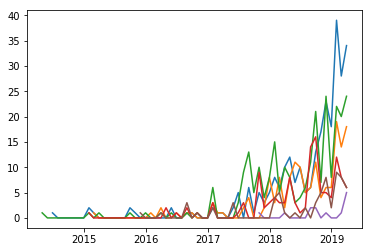

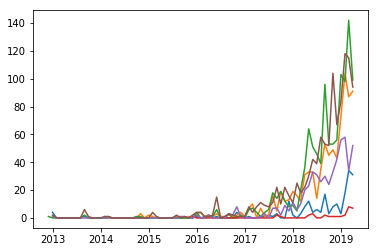

In [36]:
ssris = ['sertraline', 'fluoxetine', 'citalopram', 'escitalopram', 'fluvoxamine', 'paroxetine']
for ssri in ssris: 
    PlotFreq(ssri, antideps)
plt.show()

brand_names = ['Celexa', 'Lexapro', 'Prozac', 'Luvox', 'Paxil', 'Zoloft']

for name in brand_names: 
    PlotFreq(name, antideps)
plt.show()

In [38]:
def FreqSeries(df, offset, word, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        freq = cur_vocab[word]
        my_dict[cur_start] = freq
        cur_start = cur_end
    
    return my_dict

1319008914 1553632374


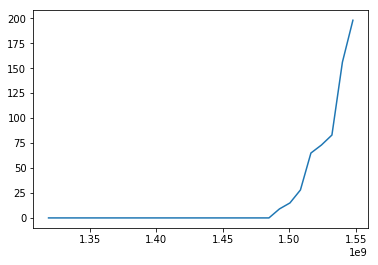

In [39]:
freq_test = FreqSeries(no_dups, 2629743*3, 'sertraline', 5)

plt.plot(freq_test.keys(), freq_test.values())

In [30]:
def FreqFaster(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    #nested dict structure
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        for word in words: 
            freq = cur_vocab[word]
            
            #np.nan behavior desirable for computing correlations later
            if freq <= 0: 
                my_dict[word][cur_start] = np.nan
            else: 
                my_dict[word][cur_start] = freq
        cur_start = cur_end
    
    return my_dict

In [31]:
test_words = ['ssri', 'snri', 'maoi', 'antidepressant']
faster_freq_test = FreqFaster(no_dups, 2629743*3, test_words, 5)

1319008914 1553632374


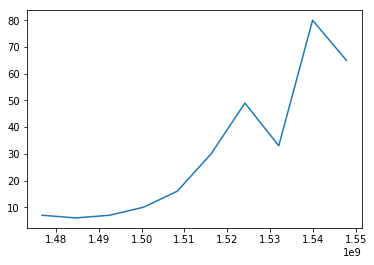

In [32]:
plt.plot(faster_freq_test['snri'].keys(), faster_freq_test['snri'].values())

In [61]:
def Rank(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    #nested dict structure
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        for word in words: 
            freq = cur_vocab[word]
            
            #np.nan behavior desirable for computing correlations later
            if freq <= 0: 
                my_dict[word][cur_start] = np.nan
            else: 
                my_dict[word][cur_start] = freq
        cur_start = cur_end
    
    return my_dict

In [62]:
# def Rank(df, offset, words, threshold): 
#     start = df['created_utc'].min()
#     end = df['created_utc'].max()
#     print(start, end)
#     cur_start = start
    
#     #initialize the cumulative vocab as an empty set
#     cum_vocab = Counter()
#     my_dict = dict()
    
#     #nested dict structure
#     for word in words: 
#         my_dict[word] = dict()
    
#     while cur_start < end: 
#         cur_end = cur_start + offset

#         #subset df, make vocab
#         cur_df = TimeSubset(cur_start, cur_end, df) 
#         cur_vocab = makeVocab(cur_df, threshold)
        
#         #generate rank dictionary
#         rank_dict = dict((item[1][0], item[0]) for item in enumerate(cur_vocab.most_common()))
        
#         for word in words: 
#             freq = cur_vocab[word]
            
#             #np.nan behavior desirable for computing correlations later
#             if freq <= 0: 
#                 my_dict[word][cur_start] = np.nan
#             else: 
                
#                 #replace with rank
#                 my_dict[word][cur_start] = rank_dict[word]
#         cur_start = cur_end
    
#     return my_dict

In [63]:
rank_test = Rank(no_dups, 2629743*3, test_words, 5)

1319008914 1553632374


In [72]:
def NormedRank(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    #nested dict structure
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        vocab_size = len(cur_vocab.items())
        
        #generate rank dictionary
        rank_dict = dict((item[1][0], item[0]) for item in enumerate(cur_vocab.most_common()))
        
        for word in words: 
            freq = cur_vocab[word]
            
            #np.nan behavior desirable for computing correlations later
            if freq <= 0: 
                my_dict[word][cur_start] = np.nan
            else: 
                
                #replace with rank
                my_dict[word][cur_start] = rank_dict[word]/vocab_size
        cur_start = cur_end
    
    return my_dict

In [73]:
normed_rank_test = NormedRank(no_dups, 2629743*3, test_words, 5)

1319008914 1553632374


# Extracting and plotting dissemination metrics over time: 

## Identifying innovations: 

In [43]:
#iterate over "months"-start with earliest time stamp in dataset
def IterOffset(df, offset): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df
        cur_df = TimeSubset(cur_start, cur_end, df)
        
        #get set of words that are in these posts
        print("making vocab")
        
        #set cutoff for word to appear at 5, per Altmann et al.
        #cutoff introduces a word when it reaches the N_w = 5 threshold, not 
        cur_vocab = makeVocab(cur_df, 5)
        cur_set = set(cur_vocab.keys())
        cum_set = set(cum_vocab.keys())
        
        if cur_start > start: 
            print("Start-End:", datetime.utcfromtimestamp(cur_start).strftime('%Y-%m-%d %H:%M:%S'), datetime.utcfromtimestamp(cur_end).strftime('%Y-%m-%d %H:%M:%S'))
            innovations = cur_set - cum_set
            print(innovations)

        #update cumulative vocab and start time
        cum_vocab = cum_vocab + cur_vocab
        cur_start = cur_end

#consider success of *innovations* within the community--words that start at 0 and end up at some higher frequency

#separate out by POS

#consider standard and nonstandard words--is there a difference between the two? 



In [44]:
IterOffset(no_dups, 2629743)

1319008914 1553632374
making vocab
making vocab
Start-End: 2011-11-18 17:50:57 2011-12-19 04:20:00
set()
making vocab
Start-End: 2011-12-19 04:20:00 2012-01-18 14:49:03
set()
making vocab
Start-End: 2012-01-18 14:49:03 2012-02-18 01:18:06
set()
making vocab
Start-End: 2012-02-18 01:18:06 2012-03-19 11:47:09
set()
making vocab
Start-End: 2012-03-19 11:47:09 2012-04-18 22:16:12
set()
making vocab
Start-End: 2012-04-18 22:16:12 2012-05-19 08:45:15
set()
making vocab
Start-End: 2012-05-19 08:45:15 2012-06-18 19:14:18
set()
making vocab
Start-End: 2012-06-18 19:14:18 2012-07-19 05:43:21
set()
making vocab
Start-End: 2012-07-19 05:43:21 2012-08-18 16:12:24
set()
making vocab
Start-End: 2012-08-18 16:12:24 2012-09-18 02:41:27
set()
making vocab
Start-End: 2012-09-18 02:41:27 2012-10-18 13:10:30
set()
making vocab
Start-End: 2012-10-18 13:10:30 2012-11-17 23:39:33
set()
making vocab
Start-End: 2012-11-17 23:39:33 2012-12-18 10:08:36
{'this', 'they'}
making vocab
Start-End: 2012-12-18 10:08:36 

Start-End: 2017-05-19 13:48:15 2017-06-19 00:17:18
{'worst', 'personal', 'tardive', 'friend', 'pill', 'general', 'appointment', 'believe', 'trazodone', '10', 'similar', 'longterm', 'reason', 'quick', 'others', 'fine', 'later', 'stick', 'issue', 'negative', 'completely', 'discontinuation', 'guess'}
making vocab
Start-End: 2017-06-19 00:17:18 2017-07-19 10:46:21
{'diet', '150mg', 'prostate', 'line', 'big', 'makes', '1', 'absolutely', 'seem', 'old', 'serotoninergic', 'asking', 'study', 'wb', 'sense', 'strong', 'hell', 'seeing', 'home', 'several', 'come', 'honestly', 'couple', 'us', 'cutting', 'cut', 'anxious', 'receptor', 'anyway', 'benzos', 'caffeine', 'ad', 'suicidal', 'minor', 'hopefully', 'please', 'understand', 'continue', '20', 'myself', 'lack', 'basically', 'switching', 'experiencing', 'within', 'coming', 'panic', '10mg', 'course', 'throughout', 'during', 'obviously', 'exactly', 'hallucinations', 'op', 'withdrawals', 'drive', 'benefit', 'prescribe', 'related', 'results', 'combo', '

Start-End: 2018-02-17 12:09:42 2018-03-19 22:38:45
{'sweats', 'vortioxetine', 'lamotrigine', 'turn', 'efficacy', 'regarding', 'contact', 'ejaculation', 'parents', 'further', 'normally', 'aware', 'cravings', 'xr', 'holding', 'metabolized', 'against', 'push', 'isn', 'above', 'clearly', 'explain', 'truly', 'wouldn', 'uncommon', 'decent', 'tramadol', 'cbt', 'immediate', 'towards', 'trintellex', 'kept', 'trauma', 'considered', '9', 'psychiatrists', 'symptom', 'damn', 'sooner', 'situational', 'ideally', 'herehttpsurvivingantidepressantsorgtopic', 'migraines', 'nowhere', 'kick', 'respond', 'middle', 'hands', 'tolerance', 'cns', 'edge', 'prior', 'receptors', 'emotionally', 'learn', 'diphenhydramine', 'kratom', 'agomelatine', 'mgday', 'lots', 'increases', 'increasing', 'actions', 'fda', 'fix', 'decision', 'necessarily', 'actual', 'pdoc', 'intense', 'bc', 'upon', 'anecdotally', 'mainly', 'buy', 'left', 'among', 'commonly', '40mg', 'number', 'understanding', 'waiting', 'seek', 'regular', 'regimen

Start-End: 2018-09-18 13:33:03 2018-10-19 00:02:06
{'ejaculate', 'resolved', 'recommendation', 'pm', 'thailand', 'clinic', 'walking', 'messing', 'potent', 'valproate', 'disappeared', 'country', '😭', 'trazadone', 'relate', 'average', 'massive', 'tolerable', 'moments', 'settle', 'digestive', 'nerve', 'recreational', 'hasn', 'ultimately', 'greatly', 'path', 'counseling', 'broke', 'tinnitus', '60mg', 'erections', 'varies', 'productive', 'unique', 'healing', 'illegal', 'absolute', 'shrooms', 'moods', 'yoga', 'suicides', '3a4', 'pharma', 'student', 'erection', 'correct', 'sadly', 'dying', 'beta', 'luckily', 'terrifying', 'attempts', 'stressed', 'intended', 'key', 'onto', 'correctly', 'sensation', 'responding', 'fell', 'rarely', 'prescriber', 'psilocybin', 'child', 'frequency', 'luvox', 'racing'}
making vocab
Start-End: 2018-10-19 00:02:06 2018-11-18 10:31:09
{'5th', 'negatives', 'scares', 'kids', 'shortage', 'rebound', 'road', 'proven', 'chemicals', 'concussion', 'neither', 'impact', 'motiva

Start-End: 2019-02-17 17:58:18 2019-03-20 04:27:21
{'outlook', '👍', 'heavily', 'dreaming', 'ki', 'weakness', 'drs', 'basic', 'sustained', 'reference', 'listening', 'professionals', 'quinidine', 'dextromethorphan', 'instance', 'mcg', 'eliminate', 'indication', 'factors', 'cough', 'ears', 'site', 'aspects', 'toward', 'whose', 'surely', 'ha', 'tms', '😅', 'bringing', 'mindful', 'description', 'usage', 'local', 'calmed', 'round', 'appeal', 'messages', 'background', 'pleasant', 'games', 'mdd', 'infusions', 'burden', 'persistent', 'meet', 'aswell', 'discussing', 'equally', '450mg', 'service', 'closely', 'community', 'bumped', 'relationships', 'wasted', 'separate', '400', 'argument', 'surveillance', 'miracle', 'manufacturers', 'apple', 'subject', 'pharmacies', 'loves', 'traditional', 'risky', 'poster', '🤔', 'honesty', 'premature', 'provided', 'whoever', 'fault', 'returning', 'hurts', 'blunted', 'lows', 'observation', 'brother', 'narrow', 'ashamed', 'savings', 'review', 'gum', 'cetirizine', 'el

## Calculating dissemination metrics over time: 

In [45]:
def D_USeries(df, offset, word, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        D_U = getD_U(word, cur_df, cur_vocab)
        my_dict[cur_start] = D_U
        cur_start = cur_end
    
    return my_dict

1319008914 1553632374
division by zero
division by zero


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


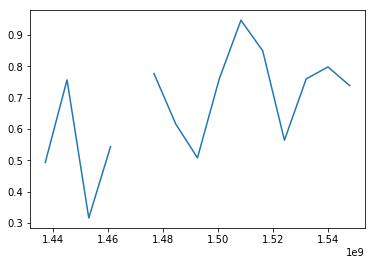

In [46]:
test_dict = D_USeries(no_dups, 2629743*3, 'antidepressant', 5)
plt.plot(test_dict.keys(), test_dict.values())

In [47]:
def FasterD_USeries(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset
        print(cur_start, cur_end)

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        
        for word in words: 
            D_U = getD_U(word, cur_df, cur_vocab)
            my_dict[word][cur_start] = D_U
        cur_start = cur_end 
    return my_dict

In [48]:
faster_d_u_test = FasterD_USeries(no_dups, 2629743*3, test_words, 5)

1319008914 1326898143
1326898143 1334787372
division by zero
division by zero
division by zero
division by zero
1334787372 1342676601
1342676601 1350565830
division by zero
division by zero
division by zero
division by zero
1350565830 1358455059
1358455059 1366344288


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


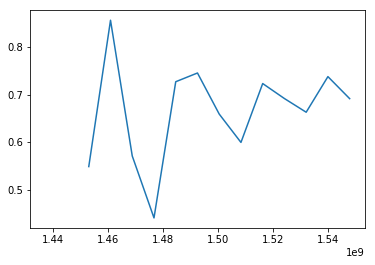

In [49]:
plt.plot(faster_d_u_test['ssri'].keys(), faster_d_u_test['ssri'].values())

In [50]:
def FasterD_TSeries(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset
        print(cur_start, cur_end)

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_T
        for word in words: 
            D_T = getD_T(word, cur_df, cur_vocab)
            my_dict[word][cur_start] = D_T
        cur_start = cur_end 
    return my_dict

In [51]:
faster_d_t_test = FasterD_TSeries(no_dups, 2629743*3, test_words, 5)

1319008914 1326898143


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


1326898143 1334787372
division by zero
division by zero
division by zero
division by zero
1334787372 1342676601
1342676601 1350565830
division by zero
division by zero
division by zero
division by zero
1350565830 1358455059
1358455059 1366344288
1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


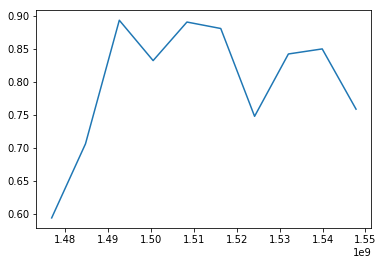

In [55]:
plt.plot(faster_d_t_test['snri'].keys(), faster_d_t_test['snri'].values())

In [56]:
#get D_L
def D_LSeries(df, offset, word, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    my_dict = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        if cur_df.shape[0] <= 0: 
            d_L = np.nan
        
        else: 
            display(cur_df.shape)
            cur_vocab = makeVocab(cur_df, threshold)
            if word in cur_vocab.keys():                 
                #3 to get trigrams
                dl_df = getD_L(cur_df, 3)
                
                #a bit of a cheap hack, works under assumption that words in df are unique
                #if time permits: index by word
                d_L = dl_df[dl_df['word'] == word].iloc[0]['D_L']
                print(d_L)
                
            else: 
                d_L = np.nan
        
        #update dict
        my_dict[cur_start]= d_L
        
        cur_start = cur_end
        
            
    #test for later
    print(word + ":\n" + str(list(my_dict.items())))
    return my_dict

In [57]:
d_l_test = D_LSeries(no_dups, 2629743*3, 'antidepressant', 5)

1319008914 1553632374


(33, 42)

(2, 42)

(5, 42)

(6, 42)

(4, 42)

(9, 42)

(17, 42)

(12, 42)

(21, 42)

(28, 42)

(11, 42)

(16, 42)

(32, 42)

(25, 42)

(102, 42)

0.03691453652669674


(85, 42)

0.030752531998985866


(146, 42)

-0.011602177335934272


(146, 42)

-0.04819936888188048


(214, 42)

(272, 42)

0.07964370381523977


(467, 42)

0.06610413529695158


(659, 42)

0.043995909088825336


(1393, 42)

-0.007763399934755277


(1396, 42)

0.07115534042809113


(2502, 42)

0.09605102613735639


(3440, 42)

0.06894767443035832


(4460, 42)

0.03927896360217531


(6560, 42)

0.015093885592694534


(8550, 42)

0.04984939480144579
antidepressant:
[(1319008914, nan), (1326898143, nan), (1334787372, nan), (1342676601, nan), (1350565830, nan), (1358455059, nan), (1366344288, nan), (1374233517, nan), (1382122746, nan), (1390011975, nan), (1397901204, nan), (1405790433, nan), (1413679662, nan), (1421568891, nan), (1429458120, nan), (1437347349, 0.03691453652669674), (1445236578, 0.030752531998985866), (1453125807, -0.011602177335934272), (1461015036, -0.04819936888188048), (1468904265, nan), (1476793494, 0.07964370381523977), (1484682723, 0.06610413529695158), (1492571952, 0.043995909088825336), (1500461181, -0.007763399934755277), (1508350410, 0.07115534042809113), (1516239639, 0.09605102613735639), (1524128868, 0.06894767443035832), (1532018097, 0.03927896360217531), (1539907326, 0.015093885592694534), (1547796555, 0.04984939480144579)]


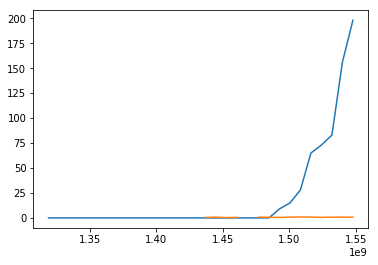

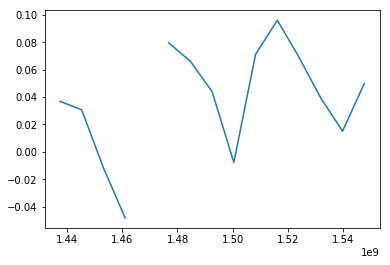

In [58]:
plt.plot(freq_test.keys(), freq_test.values())
plt.plot(test_dict.keys(), test_dict.values())
plt.show()
plt.plot(d_l_test.keys(), d_l_test.values())

In [101]:
#get D_L
def FasterD_LSeries(df, offset, words, threshold): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    my_dict = dict()
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        if cur_df.shape[0] <= 0: 
            d_L = np.nan
        
        else: 
            display(cur_df.shape)
            cur_vocab = makeVocab(cur_df, threshold)
            
            dl_df = getD_L(cur_df, 3)
            for word in words:
                if word in cur_vocab.keys(): 
                    #a bit of a cheap hack, works under assumption that words in df are unique
                    #if time permits: index by word
                    d_L = dl_df[dl_df['word'] == word].iloc[0]['D_L']
                    my_dict[word][cur_start] = d_L
                    print(d_L)
                
                else: 
                    d_L = np.nan
                    my_dict[word][cur_start] = d_L
        
        cur_start = cur_end
        
            
    #test for later
    print(word + ":\n" + str(list(my_dict.items())))
    return my_dict

In [102]:
faster_d_l_test = FasterD_LSeries(no_dups, 2629743*3, test_words, 5)

1319008914 1553632374


(33, 42)

(2, 42)

(5, 42)

(6, 42)

(4, 42)

(9, 42)

(17, 42)

(12, 42)

(21, 42)

(28, 42)

(11, 42)

(16, 42)

(32, 42)

(25, 42)

(102, 42)

0.030765734715508142
0.03691453652669674


(85, 42)

0.030752531998985866


(146, 42)

-0.02393142364368428
-0.011602177335934272


(146, 42)

0.05544644747726046
-0.04819936888188048


(214, 42)

0.060080892748076486
0.04481010418779929


(272, 42)

-0.15613047714829698
0.06309644604585074
0.07745667093604114
0.07964370381523977


(467, 42)

0.05816449272882718
0.04781229341567439
0.051716703657286534
0.06610413529695158


(659, 42)

0.05380083992133056
0.0561483361476256
-0.005398578349294247
0.043995909088825336


(1393, 42)

0.0805111275291921
0.03649727237962486
-0.007763399934755277


(1396, 42)

0.0325096800614757
0.09825170045659881
0.07115534042809113


(2502, 42)

0.040263135655994375
-0.02000323654228353
0.09605102613735639


(3440, 42)

0.05317143714477801
0.04279226376052492
0.06894767443035832


(4460, 42)

0.08552104467573152
0.09679492470275797
0.03927896360217531


(6560, 42)

0.022449761712676874
0.03166274461131646
0.09646710960098481
0.015093885592694534


(8550, 42)

0.04111355029333552
0.12222756175560434
0.09280693347848512
0.04984939480144579
antidepressant:
[('ssri', {1319008914: nan, 1326898143: nan, 1334787372: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: 0.030765734715508142, 1445236578: nan, 1453125807: -0.02393142364368428, 1461015036: 0.05544644747726046, 1468904265: 0.060080892748076486, 1476793494: -0.15613047714829698, 1484682723: 0.05816449272882718, 1492571952: 0.05380083992133056, 1500461181: 0.0805111275291921, 1508350410: 0.0325096800614757, 1516239639: 0.040263135655994375, 1524128868: 0.05317143714477801, 1532018097: 0.08552104467573152, 1539907326: 0.022449761712676874, 1547796555: 0.04111355029333552}), ('snri', {1319008914: nan, 1326898143: nan, 1334787372: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901

In [100]:
print(faster_d_l_test['antidepressant'])

{1437347349: 0.03691453652669674, 1445236578: 0.030752531998985866, 1453125807: -0.011602177335934272, 1461015036: -0.04819936888188048, 1476793494: 0.07964370381523977, 1484682723: 0.06610413529695158, 1492571952: 0.043995909088825336, 1500461181: -0.007763399934755277, 1508350410: 0.07115534042809113, 1516239639: 0.09605102613735639, 1524128868: 0.06894767443035832, 1532018097: 0.03927896360217531, 1539907326: 0.015093885592694534, 1547796555: 0.04984939480144579}


In [64]:
#get D_S (morphological dissemination)
def D_SSeries(df, offset, word, threshold, suffixes): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    #print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        D_S = getD_S(word, cur_df, cur_vocab, suffixes)
        #print(D_S)
        my_dict[cur_start] = D_S
        cur_start = cur_end 
        
    #test for later
    print(word + ":\n" + str(list(my_dict.items())))
    return my_dict


In [65]:
suffix_test = D_SSeries(no_dups, 2629743*3, 'antidepressant', 5, suffixes)

antidepressant:
[(1319008914, 0.0), (1326898143, nan), (1334787372, 0.0), (1342676601, nan), (1350565830, 0.0), (1358455059, 0.0), (1366344288, 0.0), (1374233517, 0.0), (1382122746, 0.0), (1390011975, 0.0), (1397901204, 0.0), (1405790433, 0.0), (1413679662, 0.0), (1421568891, 0.0036991368680641184), (1429458120, 0.006528835690968444), (1437347349, 0.001982651796778191), (1445236578, 0.004594180704441042), (1453125807, 0.004290617848970252), (1461015036, 0.0019321338002656683), (1468904265, 0.0015478033099178474), (1476793494, 0.003151095005514416), (1484682723, 0.003341687552213868), (1492571952, 0.002587090163934426), (1500461181, 0.0017778622224634928), (1508350410, 0.0013856154981740955), (1516239639, 0.001665828086541469), (1524128868, 0.0016422920830387413), (1532018097, 0.0016884562011024373), (1539907326, 0.0015772731419222133), (1547796555, 0.0012067379731977145)]


In [68]:
#get D_P (morphological dissemination)
def D_PSeries(df, offset, word, threshold, prefixes): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    print(start, end)
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        D_P = getD_P(word, cur_df, cur_vocab, prefixes)
        print(D_P)
        my_dict[cur_start] = D_P
        cur_start = cur_end 
        
    #test for later
    print(word + ":\n" + str(list(my_dict.items())))
    return my_dict


In [69]:
prefix_test = D_PSeries(no_dups, 2629743*3, 'sad', 5, prefixes)

1319008914 1553632374
0.0
nan
0.0
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
sad:
[(1319008914, 0.0), (1326898143, nan), (1334787372, 0.0), (1342676601, nan), (1350565830, 0.0), (1358455059, 0.0), (1366344288, 0.0), (1374233517, 0.0), (1382122746, 0.0), (1390011975, 0.0), (1397901204, 0.0), (1405790433, 0.0), (1413679662, 0.0), (1421568891, 0.0), (1429458120, 0.0), (1437347349, 0.0), (1445236578, 0.0), (1453125807, 0.0), (1461015036, 0.0), (1468904265, 0.0), (1476793494, 0.0), (1484682723, 0.0), (1492571952, 0.0), (1500461181, 0.0), (1508350410, 0.0), (1516239639, 0.0), (1524128868, 0.0), (1532018097, 0.0), (1539907326, 0.0), (1547796555, 0.0)]


In [70]:
#get D_P (morphological dissemination)
def FasterD_PSeries(df, offset, words, threshold, prefixes): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset
        print(cur_start, cur_end)

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        for word in words: 
            D_P = getD_P(word, cur_df, cur_vocab, prefixes)
            my_dict[word][cur_start] = D_P
        cur_start = cur_end 
        
    return my_dict


In [71]:
faster_d_p_test = FasterD_PSeries(no_dups, 2629743*3, test_words, 5, prefixes)

1319008914 1326898143
1326898143 1334787372
1334787372 1342676601
1342676601 1350565830
1350565830 1358455059
1358455059 1366344288
1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


In [72]:
print(faster_d_p_test['antidepressant'])

{1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 1421568891: 0.0, 1429458120: 0.0, 1437347349: 0.0, 1445236578: 0.0, 1453125807: 0.0, 1461015036: 0.0, 1468904265: 0.0, 1476793494: 0.0, 1484682723: 0.0, 1492571952: 0.0, 1500461181: 0.0, 1508350410: 0.0, 1516239639: 0.0, 1524128868: 0.0, 1532018097: 0.0, 1539907326: 0.0, 1547796555: 0.0}


In [73]:
#get D_S (morphological dissemination)
def FasterD_SSeries(df, offset, words, threshold, suffixes): 
    start = df['created_utc'].min()
    end = df['created_utc'].max()
    cur_start = start
    
    #initialize the cumulative vocab as an empty set
    cum_vocab = Counter()
    my_dict = dict()
    
    for word in words: 
        my_dict[word] = dict()
    
    while cur_start < end: 
        cur_end = cur_start + offset
        print(cur_start, cur_end)

        #subset df, make vocab
        cur_df = TimeSubset(cur_start, cur_end, df) 
        cur_vocab = makeVocab(cur_df, threshold)
        
        #get D_U
        for word in words: 
            D_S = getD_S(word, cur_df, cur_vocab, suffixes)
            my_dict[word][cur_start] = D_S
        cur_start = cur_end 
        
    return my_dict


In [74]:
faster_d_s_test = FasterD_SSeries(no_dups, 2629743*3, test_words, 5, suffixes)

1319008914 1326898143
1326898143 1334787372
1334787372 1342676601
1342676601 1350565830
1350565830 1358455059
1358455059 1366344288
1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


# Complete run with all words: 

In [75]:
#make initial dataframe
all_dfs = []
for word_list in all_words: 
    list_df = pd.DataFrame()
    
    #all words to lowercase
    list_df['word'] = word_list[1]
    
    list_df['word'] = list_df['word'].map(lambda x: x.lower())
    list_df['category'] = word_list[0]
    display(list_df.head())
    all_dfs.append(list_df)

#sanity check(s)
final_df = pd.concat(all_dfs)
display(final_df.head())
display(final_df.shape)

word  category
0  citalopram    generics
1  escitalopram  generics
2  fluoxetine    generics
3  fluvoxamine   generics
4  paroxetine    generics

word     category
0  celexa    brand_names
1  cipramil  brand_names
2  lexapro   brand_names
3  cipralex  brand_names
4  prozac    brand_names

word       category
0  selective serotonin reuptake inhibitors        cat_no_abbrev
1  serotonin–norepinephrine reuptake inhibitors   cat_no_abbrev
2  serotonin modulator and stimulators            cat_no_abbrev
3  serotonin antagonist and reuptake inhibitors   cat_no_abbrev
4  norepinephrine reuptake inhibitors             cat_no_abbrev

word       category
0  ssris  cat_abbrev_pl
1  snris  cat_abbrev_pl
2  smss   cat_abbrev_pl
3  saris  cat_abbrev_pl
4  nris   cat_abbrev_pl

word         category
0  ssri  cat_abbrev_sing
1  snri  cat_abbrev_sing
2  sms   cat_abbrev_sing
3  sari  cat_abbrev_sing
4  nri   cat_abbrev_sing

word  category
0  citalopram    generics
1  escitalopram  generics
2  fluoxetine    generics
3  fluvoxamine   generics
4  paroxetine    generics

(235, 2)

In [76]:
faster_freq = FreqFaster(no_dups, 2629743*3, final_df['word'].tolist(), 5)

1319008914 1553632374


In [77]:
final_df['freq'] = final_df['word'].map(lambda x: faster_freq[x])
display(final_df.head())

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}       
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}      
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}         
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}  
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}

In [79]:
faster_d_s = FasterD_SSeries(no_dups, 2629743*3, final_df['word'].tolist(), 5, suffixes)

1319008914 1326898143
1326898143 1334787372
1334787372 1342676601
1342676601 1350565830
1350565830 1358455059
1358455059 1366344288
1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


In [82]:
final_df['d_s'] = final_df['word'].map(lambda x: faster_d_s[x])
display(final_df.head())

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 1421568891

In [83]:
faster_d_p = FasterD_PSeries(no_dups, 2629743*3, final_df['word'].tolist(), 5, prefixes)

1319008914 1326898143
1326898143 1334787372
1334787372 1342676601
1342676601 1350565830
1350565830 1358455059
1358455059 1366344288
1366344288 1374233517
1374233517 1382122746
1382122746 1390011975
1390011975 1397901204
1397901204 1405790433
1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


In [84]:
final_df['d_p'] = final_df['word'].map(lambda x: faster_d_p[x])
display(final_df.head())

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [103]:
faster_d_l = FasterD_LSeries(no_dups, 2629743*3, final_df['word'].tolist(), 5)

1319008914 1553632374


(33, 42)

0.04346929566805402


(2, 42)

(5, 42)

(6, 42)

(4, 42)

(9, 42)

(17, 42)

0.03280237545353826


(12, 42)

(21, 42)

(28, 42)

-0.11966743423856974


(11, 42)

(16, 42)

0.026755561211107892


(32, 42)

-0.01826201761145363
0.02725481095803639
0.02880610288783192


(25, 42)

(102, 42)

-0.09229719495330935
0.03258229465451867
0.028668670167302235
0.03691453652669674
0.028668670167302235
-0.05442908233511101
0.028668670167302235
0.030765734715508142


(85, 42)

0.03842075225154362
0.030752531998985866
0.04115765852491693
0.04115765852491693
-0.015723610888031647
-0.026405881840962486


(146, 42)

0.03908537042662674
0.03908537042662674
-0.04865181290973597
0.04132268469116118
0.03650258065647183
0.04132268469116118
0.04945735280508945
-0.002248618997213736
0.036217661830582504
-0.030585354868446935
0.04132268469116118
-0.02393142364368428


(146, 42)

0.049091368622073084
-0.0052504901509187185
-0.015256238703880598
0.023135427942006626
-0.06994360425558366
0.0039298524823241365
0.05356889845086421
0.012794846504877277
-0.12730585897153457
0.04013438804593239
-0.017024025794015962
0.05544644747726046


(214, 42)

-0.01574441729578613
0.04481010418779929
0.018766490633192134
0.04775194644023584
-0.0015157861370584946
0.060080892748076486
-0.14090756024979223
0.06435836155612762
0.07829352356078978
-0.10747544907085693
0.06561762376864344
0.060080892748076486
0.04481010418779929


(272, 42)

0.06309644604585074
0.06733893263945534
0.045157527744070336
0.09128735932299081
0.08276422222162694
0.07442852787465037
0.06824525361713096
0.08098427939456077
-0.04016406828026131
0.08098427939456077
-0.15613047714829698
0.06309644604585074
0.07745667093604114


(467, 42)

-0.2049524097731199
-0.06604690869553709
0.055098857647941646
-0.08497368684494688
-0.13450926337828006
0.051716703657286534
-0.05241434253001431
-0.2049524097731199
0.034144830511209534
0.04781229341567439
-0.021525219848850252
0.051716703657286534
0.045444385765142314
0.055098857647941646
0.03719781615967266
0.06610413529695158
0.06075075595988588
0.002027719951362972
0.051741855056456565
0.025766678997116266
0.04781229341567439
0.055098857647941646
0.07438732427462202
0.05808212889410225
0.05816449272882718
0.04781229341567439
0.051716703657286534


(659, 42)

0.03240092863500754
-0.013658059061200323
0.06330298207492824
0.0714929749141957
0.05587739838396644
-0.18923869653745928
0.045295793515623295
-0.1497867871254117
0.06630248031068886
0.06986729923537816
0.0934668682596973
0.0836384239479937
0.03596005017297621
0.08742462215544133
0.0745983839553146
0.03869583154654066
0.01346213469579105
0.07723987236299745
0.07073079294797058
0.06630248031068886
-0.12105383413913628
0.09457926808274397
0.08708476262247977
0.051759835490654105
0.05380083992133056
0.0561483361476256
-0.005398578349294247


(1393, 42)

0.0880208706207739
0.07598643933332738
0.04254813988103878
0.08282512773880324
0.060352271886744635
0.09006974308265558
0.08333295843300181
-0.12757802391732787
-0.04061566427722685
0.04254813988103878
0.0671698365601241
0.050065011738174015
0.02100052123103424
0.062482578086798135
-0.009656947447898467
0.05294079814545416
0.05255726361224511
0.05246402465759825
0.0541760077305522
0.05774017883632521
0.06087614220173254
0.07922352631645335
0.07598643933332738
0.05246402465759825
-0.2100393423907292
0.031254329176876094
0.04058466081686518
0.05474353287662659
0.06110982164829171
0.0844927298168896
0.06356013564983032
0.0805111275291921
0.03649727237962486


(1396, 42)

-0.004051291066414997
0.06452557424670591
0.06616823751452117
0.10534795626595894
0.04090220076498108
0.07864252874782807
0.11479844951967966
0.10410858470307183
0.11140377407102786
0.007665327280539813
0.06616823751452117
0.05236887547078428
0.029233188314645275
0.06482374112048817
0.10341684809378293
0.02904996917986402
0.10581038509275054
0.07195517640070115
0.046584668191646195
0.07864252874782807
0.04447631202415714
0.0771982912587661
0.025059111094307696
0.06597306743806008
0.0771982912587661
-0.14657831281619327
0.011240323466968682
0.007436102901306363
0.06482374112048817
0.10366216985833443
0.07745156218394289
0.021287236179792668
0.0325096800614757
0.09825170045659881
-0.05295929453589521


(2502, 42)

0.08184848325568517
0.10869826753826217
0.12275132313905956
0.09748676777366372
0.09150139598302331
0.08471151126647891
0.14108933311561866
0.09337038832829903
0.10044520602614693
0.14390899256936063
0.1349780622375949
0.0735482771798166
0.08928197193948506
0.09415829463443748
0.08928197193948506
0.0735482771798166
0.12275132313905956
0.12184643803666972
0.045043533389243606
0.06079069588253638
0.09032954460695652
0.11031056003585604
0.12775958018336375
0.1311478488527129
0.11160844011280924
0.09135562322295332
0.08232932757973632
0.11674004704297136
0.08928197193948506
0.09652719252620123
0.1133558928977374
0.07227432905945053
-0.28420091713016404
0.07396684782156804
-0.09539708880525266
0.12396573966905056
0.030739786143034298
0.11477129541046338
0.13876306372088276
0.10869826753826217
0.08928197193948506
0.040263135655994375
-0.02000323654228353
-0.20297056118530232


(3440, 42)

0.10346342046756263
0.05117421940222133
0.12072629237135057
0.1058034596437123
0.13376056023178595
0.10847589492966492
0.09398060748762216
0.10069730938913013
0.07595049649403052
0.13444591714029475
0.10599753877243456
0.09457864360861112
0.0934126128751398
-0.026899073141384733
-0.039445362001324646
0.07848461479890245
0.08315974844478724
0.12674993423787928
0.07848461479890245
0.07318438541559802
0.08315974844478724
0.12072629237135057
0.047455257872555556
0.04032166523235947
0.08860126997808448
0.0696574978591924
0.07848461479890245
0.07482533208329034
0.046521736248974044
0.10606385809811503
0.0751127069442985
0.04541942046194025
0.08584221943432624
-0.08096629441166048
0.06924115651738028
0.0785767413647962
-0.008526762190727233
0.07318438541559802
0.1167913381988388
0.08315974844478724
0.06706571963507857
-0.22494869258601202
0.06757231929185892
-0.051631405431148636
0.0873417979984823
0.0726249500002707
0.017713051838623706
0.13597901824339775
0.09749385633671981
-0.054111323431

(4460, 42)

0.10204779649901585
0.10418650620075542
0.12950664838517678
0.07479622933116747
0.0873341911210348
0.09605855522411755
0.08147169261050768
0.1120287631139476
0.08147169261050768
0.02156497618339337
0.12816572759282252
0.06296894850486812
0.05228053214253503
0.1561104662458339
0.11447600979454364
0.03738031562322597
0.09691742722284902
0.08725424192591236
0.08230357098058771
-0.14636060925559313
0.032681528441075525
0.09235481190286254
0.12950664838517678
0.08112560702374694
0.03137217373294554
0.11727083709235187
0.07156576835757544
0.10481282449760698
0.03177768408957782
0.045821353999306424
0.11242485467095253
0.11430132684101757
0.09378468797656137
0.1010448148292098
0.04077431150018018
0.019724061811178473
0.08147169261050768
0.05228053214253503
0.12237140706930205
-0.29696907046466414
0.10552353914700507
0.06344958786282984
0.08147169261050768
0.08565191906486636
0.09691742722284902
0.15056820524421077
0.11643918127207975
-0.022611604536606045
-0.25500054401070527
0.09235481190286

(6560, 42)

0.08108532076814523
0.047917184189684825
0.07252552555592917
0.0680921372709733
0.09432411388782835
0.14006563689606288
0.1418726741154055
0.055359185779915165
0.11856993061037446
0.09820422053220579
0.10071516436108618
0.043718412036291454
0.09597943148934984
0.10476315734269681
0.09174132987324324
0.10891013364672775
-0.2673124360808963
0.08468337820296812
0.07252552555592917
0.13780892748319218
0.04075658462743004
0.10071516436108618
0.06430462998714326
0.11250788446927906
0.07755836543049721
0.07118139051067018
0.08809626120030511
0.12299999939813056
0.08468337820296812
0.08288003631082042
0.05700504563636688
0.10083455093872651
0.1295651422547972
-0.016322649752154916
0.1158388814523037
0.08498870673987735
0.1321229898787637
-0.3238453114096318
0.0036739555651417177
0.12217515748252694
0.01406712790685205
0.0906853325547714
0.1181928359845772
0.11893996545304342
0.10947385116429587
0.12679375564307094
0.05516194874263558
0.08468337820296812
0.0036739555651417177
0.1118947599293669

(8550, 42)

0.09081157489043434
0.08599433419340219
0.085791440363022
-0.11072835269265013
0.07874425842885557
0.1258550354708854
0.11032689311748012
0.1232142893372008
0.17590261717951794
0.14191229547616402
0.13626810708439407
0.10515155906826257
0.16216237160240343
0.08423689356845765
0.09936602782777149
-0.24366530314272783
0.05466252826323004
0.12756733220221417
0.12753442259828773
0.10777058158622488
0.11500855223521134
0.13024343743828348
0.15561181301289917
0.028190517932134007
-0.2786106172285643
0.085791440363022
0.10024613129066395
0.05851733816152116
0.08423689356845765
0.023516019968305102
0.14892585723399954
0.07971308820356882
0.06465165315322707
0.15198640778304817
0.15048663638301552
0.053252859839242106
0.08227814736680727
0.10968525645588656
0.09280693347848512
0.030421719919582202
0.1192825721485744
0.12999334349658742
0.11377344064869188
0.10275693930053986
-0.3019967497333802
0.12749411706440839
0.13639148133682166
0.13934388757494975
0.12850141091884293
0.06407931935528977
0

In [105]:
final_df['d_l'] = final_df['word'].map(lambda x: faster_d_l[x])
display(final_df.head())
final_df.to_pickle('final_df.pkl')

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [92]:
faster_d_u = FasterD_USeries(no_dups, 2629743*3, final_df['word'].tolist(), 5)

1319008914 1326898143


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


1326898143 1334787372
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division 

1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


In [93]:
final_df['d_u'] = final_df['word'].map(lambda x: faster_d_u[x])
display(final_df.head())
final_df.to_pickle('final_df.pkl')

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [94]:
faster_d_t = FasterD_TSeries(no_dups, 2629743*3, final_df['word'].tolist(), 5)

1319008914 1326898143


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


1326898143 1334787372
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division 

1405790433 1413679662
1413679662 1421568891
1421568891 1429458120
1429458120 1437347349
1437347349 1445236578
1445236578 1453125807
1453125807 1461015036
1461015036 1468904265
1468904265 1476793494
1476793494 1484682723
1484682723 1492571952
1492571952 1500461181
1500461181 1508350410
1508350410 1516239639
1516239639 1524128868
1524128868 1532018097
1532018097 1539907326
1539907326 1547796555
1547796555 1555685784


In [95]:
final_df['d_t'] = final_df['word'].map(lambda x: faster_d_t[x])
display(final_df.head())
final_df.to_pickle('final_df.pkl')

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [46]:
full_df['d_l'] = full_df['word'].map(lambda x: D_LSeries(no_dups, 2629743, x, 5))

1319008914 1553632374


(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

0.08706146432627504


(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.04966042364181922


(653, 41)

0.05062640599866963


(274, 41)

0.010542470428343886


(466, 41)

0.07918813251875534


(500, 41)

0.06606611913555005


(394, 41)

(502, 41)

-0.045845236940996514


(591, 41)

-0.011483441921148696


(711, 41)

0.06570746606736533


(1200, 41)

0.10716503817263057


(1219, 41)

0.0885822995858776


(1090, 41)

0.06544149885016548


(1131, 41)

0.07271951466410442


(1425, 41)

0.10437533725182746


(1451, 41)

0.086944070188542


(1584, 41)

0.05540709206206351


(1676, 41)

0.06729001579488436


(2189, 41)

0.11706444105276503


(2695, 41)

0.05221404769778193


(3434, 41)

0.08157775321911132


(4309, 41)

0.07583425826565993


(807, 41)

0.06508430623445349
citalopram:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

0.04840076272731908


(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.01539644684543795


(502, 41)

0.052805871387610726


(591, 41)

(711, 41)

0.04913623988977145


(1200, 41)

0.0837584122402184


(1219, 41)

-0.020416180196800138


(1090, 41)

0.05633442089724916


(1131, 41)

0.07106988466102138


(1425, 41)

0.06710394245459561


(1451, 41)

0.08459997745359704


(1584, 41)

0.1020005911700057


(1676, 41)

0.04525149169197684


(2189, 41)

0.10342587623909383


(2695, 41)

-0.028581882556379945


(3434, 41)

0.15536163014921556


(4309, 41)

-0.0028387169185206673


(807, 41)

escitalopram:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

-0.20963823256312253


(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

-0.0003894014421130798


(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.07358773594041956


(502, 41)

(591, 41)

0.08951341237362342


(711, 41)

0.039915404540419974


(1200, 41)

0.09129366273438055


(1219, 41)

0.06956493622087301


(1090, 41)

0.07999247714708435


(1131, 41)

0.07595706462146623


(1425, 41)

0.09619810073089452


(1451, 41)

0.07727814995435933


(1584, 41)

0.05608992627526943


(1676, 41)

0.04525149169197684


(2189, 41)

0.07893661324800982


(2695, 41)

0.0827618717544194


(3434, 41)

0.14071079202729742


(4309, 41)

0.049932140809866965


(807, 41)

fluoxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

-0.20966970927003992


(807, 41)

fluvoxamine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

0.06979798757466149


(711, 41)

(1200, 41)

(1219, 41)

0.0935831113349197


(1090, 41)

(1131, 41)

(1425, 41)

0.013412702628109674


(1451, 41)

0.06916894624712011


(1584, 41)

0.013414614013210091


(1676, 41)

0.06289270648569634


(2189, 41)

0.04800000787866132


(2695, 41)

-0.05716079844351185


(3434, 41)

0.024376443106874035


(4309, 41)

0.11035294529560247


(807, 41)

paroxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

0.05573119967090401


(466, 41)

(500, 41)

0.049311091730878776


(394, 41)

0.09956931499903687


(502, 41)

0.004015707218178566


(591, 41)

0.04678546620282731


(711, 41)

0.0723006271468245


(1200, 41)

0.09582625646834231


(1219, 41)

0.08440578570394575


(1090, 41)

0.08219801862606957


(1131, 41)

0.10097572699395929


(1425, 41)

0.07636528460497871


(1451, 41)

0.0897028592712612


(1584, 41)

0.03621509527257594


(1676, 41)

0.10605167696500217


(2189, 41)

0.10039738856755331


(2695, 41)

0.004893500202570955


(3434, 41)

0.14319619692980812


(4309, 41)

0.08334278909744697


(807, 41)

0.0682377887871426
sertraline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.0477420038444607


(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

0.0626058171205437


(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.07927218743954523


(4309, 41)

(807, 41)

desvenlafaxine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, n

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

0.09583847885449304


(1090, 41)

-0.007790914783693648


(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.07747732887585368


(2189, 41)

(2695, 41)

0.08594004519716147


(3434, 41)

0.07927218743954523


(4309, 41)

(807, 41)

duloxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.08548233182730769


(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

levomilnacipran:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

milnacipran:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

0.033564651812500124


(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

0.048241542777757385


(500, 41)

0.049311091730878776


(394, 41)

(502, 41)

0.07648570162343615


(591, 41)

0.10636951243270909


(711, 41)

0.08465750768471025


(1200, 41)

0.06555724252423145


(1219, 41)

0.06396697855784694


(1090, 41)

0.025455409230411785


(1131, 41)

0.05990658076440036


(1425, 41)

0.09619810073089452


(1451, 41)

0.09193848931355486


(1584, 41)

0.10152727858313604


(1676, 41)

0.12044332887484366


(2189, 41)

0.07085724100819313


(2695, 41)

0.1269194178881028


(3434, 41)

0.11154112600223698


(4309, 41)

0.14326672919808292


(807, 41)

0.05756236445318352
venlafaxine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

vilazodone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

0.05335058552947958


(1200, 41)

(1219, 41)

0.061562353518836765


(1090, 41)

(1131, 41)

0.05990658076440036


(1425, 41)

0.07057111646805803


(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.118248818083182


(4309, 41)

(807, 41)

vortioxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

-0.01548221812216477


(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nefazodone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

0.0490646939394197


(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

0.06544149885016548


(1131, 41)

-0.021257252684957706


(1425, 41)

0.0417234677191054


(1451, 41)

0.008368747407057064


(1584, 41)

0.013727452485674974


(1676, 41)

-0.03164593597858589


(2189, 41)

0.0246724699775962


(2695, 41)

0.1053952140934511


(3434, 41)

0.13717130463583072


(4309, 41)

0.08391110241351463


(807, 41)

0.0529485726898713
trazodone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

0.07716177421888837


(807, 41)

atomoxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

reboxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

teniloxazine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

viloxazine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

0.04167619571778358


(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.052931975299048695


(653, 41)

0.06720247057032447


(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.09720652556969789


(502, 41)

(591, 41)

0.0817262079544463


(711, 41)

0.08982061548419829


(1200, 41)

0.09029861777956505


(1219, 41)

0.10361298514221051


(1090, 41)

0.09282450198666892


(1131, 41)

0.0971384880647701


(1425, 41)

0.07801983968674975


(1451, 41)

0.11414218509908736


(1584, 41)

0.06588560515527409


(1676, 41)

0.10720730723901628


(2189, 41)

0.10392552597362759


(2695, 41)

0.09681701319938085


(3434, 41)

0.14843010025750392


(4309, 41)

0.13077695712236093


(807, 41)

0.06627004276976756
bupropion:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

0.06917012635243491


(1131, 41)

0.05508193324142141


(1425, 41)

-0.02371817395200404


(1451, 41)

0.08109077038053325


(1584, 41)

0.013414614013210091


(1676, 41)

0.03973700089300669


(2189, 41)

0.06038909310338214


(2695, 41)

(3434, 41)

(4309, 41)

0.07716177421888837


(807, 41)

amitriptyline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

amitriptylinoxide:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

0.07301600293660293


(1584, 41)

-0.1261833161516397


(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

0.08377908991791827


(807, 41)

clomipramine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

desipramine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

dibenzepin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

dimetacrine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

dosulepin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

doxepin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

imipramine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lofepramine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

melitracen:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nitroxazepine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nortriptyline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

noxiptiline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

opipramol:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pipofezine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

protriptyline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

trimipramine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

amoxapine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

maprotiline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

mianserin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

0.038054918681714955


(172, 41)

-0.015558144392616047


(370, 41)

0.05167736710632376


(653, 41)

0.047741202365199964


(274, 41)

(466, 41)

0.05922958311480597


(500, 41)

0.04526098622157937


(394, 41)

(502, 41)

0.0748677870697505


(591, 41)

0.10794015143275626


(711, 41)

0.08922462120042418


(1200, 41)

0.05004849917356191


(1219, 41)

0.10099899243915189


(1090, 41)

0.036504493742667066


(1131, 41)

0.021241657686099202


(1425, 41)

0.1176595839552208


(1451, 41)

0.09809852158647736


(1584, 41)

0.09256986667157197


(1676, 41)

0.1090714453728614


(2189, 41)

0.06223531162604168


(2695, 41)

0.05259928193813668


(3434, 41)

0.08024937245933206


(4309, 41)

0.07086602494104355


(807, 41)

0.0713026614005976
mirtazapine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

setiptiline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

bifemelane:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

-0.03313414496725464


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

selegiline:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

metralindole:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

-0.10939642790589366


(118, 41)

(145, 41)

-0.11203836154551139


(117, 41)

(172, 41)

-0.18503839083255924


(370, 41)

-0.11928043103731589


(653, 41)

-0.1377236332405234


(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

-0.14435978007747874


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

0.08897696315893366


(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.11509644399141017


(4309, 41)

0.07716177421888837


(807, 41)

moclobemide:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pirlindole:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

toloxatone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

eprobemide:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.04254514688738409


(653, 41)

-0.07318511210295231


(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

-0.11971573967341076


(1584, 41)

0.06955564221375754


(1676, 41)

(2189, 41)

(2695, 41)

0.07735153149557616


(3434, 41)

0.08912095758814953


(4309, 41)

0.11353422122708556


(807, 41)

buspirone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.08126715765513248


(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

0.03498892574848611


(807, 41)

lithium:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

thyroxine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

triiodothyronine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807,

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

0.07027457958307926


(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.07927218743954523


(4309, 41)

(807, 41)

agomelatine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

0.09909028224364169


(807, 41)

esketamine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

0.03916572403855323


(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

0.09360266195880307


(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.06843752257839686


(2189, 41)

0.03637448661786857


(2695, 41)

(3434, 41)

0.11509644399141017


(4309, 41)

0.1140770468858685


(807, 41)

ketamine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tandospirone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

0.04475425192136484


(118, 41)

(145, 41)

(117, 41)

(172, 41)

-0.05403397357477857


(370, 41)

-0.22283990486721095


(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

0.11221441018793321


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.06843752257839686


(2189, 41)

(2695, 41)

(3434, 41)

0.02109758709467302


(4309, 41)

(807, 41)

tianeptine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

agent:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

ethyltryptamine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

indeloxazine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

medifoxamine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

oxaflozane:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pivagabine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

methionine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

-0.2288877706487069


(2189, 41)

(2695, 41)

-0.3550673506833544


(3434, 41)

(4309, 41)

(807, 41)

-0.2789098721680294
wort:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

hydroxytryptophan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tryptophan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

0.06408588054684472


(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

amisulpride:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

aripiprazole:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

brexpiprazole:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lurasidone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

olanzapine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

0.05990658076440036


(1425, 41)

(1451, 41)

(1584, 41)

0.02076547804432538


(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

quetiapine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

0.07636528460497871


(1451, 41)

(1584, 41)

(1676, 41)

0.06289270648569634


(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

risperidone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan)

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

perphenazine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

melitracen:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

-0.20963823256312253


(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

-0.0003894014421130798


(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.07358773594041956


(502, 41)

(591, 41)

0.08951341237362342


(711, 41)

0.039915404540419974


(1200, 41)

0.09129366273438055


(1219, 41)

0.06956493622087301


(1090, 41)

0.07999247714708435


(1131, 41)

0.07595706462146623


(1425, 41)

0.09619810073089452


(1451, 41)

0.07727814995435933


(1584, 41)

0.05608992627526943


(1676, 41)

0.04525149169197684


(2189, 41)

0.07893661324800982


(2695, 41)

0.0827618717544194


(3434, 41)

0.14071079202729742


(4309, 41)

0.049932140809866965


(807, 41)

fluoxetine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

trifluoperazine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

-0.10539622536251114


(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

0.04840076272731908


(274, 41)

(466, 41)

(500, 41)

-0.03447251169845078


(394, 41)

0.09188032902297305


(502, 41)

0.05636947932491676


(591, 41)

(711, 41)

0.07595125939120972


(1200, 41)

0.08157660919988885


(1219, 41)

0.06260681318261696


(1090, 41)

-0.008734172684278896


(1131, 41)

0.03716833298534006


(1425, 41)

0.07288814829819668


(1451, 41)

0.06677901154280796


(1584, 41)

0.07348166898713826


(1676, 41)

0.05561362298888639


(2189, 41)

0.0941693510282624


(2695, 41)

0.10564949015485148


(3434, 41)

0.12825514287775075


(4309, 41)

0.07726298092307538


(807, 41)

0.06431707817712118
celexa:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

cipramil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

-0.08371626730883674


(21, 41)

(34, 41)

(30, 41)

0.016623643635785168


(51, 41)

(66, 41)

0.024567245216452704


(29, 41)

(69, 41)

(47, 41)

-0.08785683895036422


(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

0.02537517171413528


(65, 41)

(148, 41)

0.05049679240247773


(204, 41)

0.062471780685365186


(118, 41)

0.03919510925846925


(145, 41)

(117, 41)

0.04430434886262091


(172, 41)

(370, 41)

0.05141376377848417


(653, 41)

0.0301307294536306


(274, 41)

0.0045623586932421745


(466, 41)

0.03958917884345947


(500, 41)

0.00929671937520471


(394, 41)

0.12050946085496417


(502, 41)

0.015183665170714455


(591, 41)

0.10789176392684663


(711, 41)

0.015781122284408866


(1200, 41)

0.0668256420037272


(1219, 41)

0.08641172348869564


(1090, 41)

-0.004562304133250983


(1131, 41)

0.03575989070153884


(1425, 41)

0.09312749511388763


(1451, 41)

0.013053002031147898


(1584, 41)

0.04625857287774249


(1676, 41)

0.02090703813913919


(2189, 41)

0.10120656744211498


(2695, 41)

0.04577764290550146


(3434, 41)

0.10011998515286002


(4309, 41)

0.06781934138118384


(807, 41)

0.05064857212218854
lexapro:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, -0.08371626730883674), (1445236578, nan), (1447866321, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

0.032497437866704004


(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

0.04869198793760976


(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

0.07250549730926137


(1131, 41)

(1425, 41)

(1451, 41)

0.0626058171205437


(1584, 41)

0.06955564221375754


(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

cipralex:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

-0.005772070655701622


(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

0.033982395765862705


(148, 41)

0.08706146432627504


(204, 41)

0.049772458366423855


(118, 41)

(145, 41)

(117, 41)

(172, 41)

0.022600973945685165


(370, 41)

0.07880552314915246


(653, 41)

0.06786850156067459


(274, 41)

0.04149609587278169


(466, 41)

0.029154945683205646


(500, 41)

0.07586718186583763


(394, 41)

0.07929616347987922


(502, 41)

0.05951280429513739


(591, 41)

0.10474823185731186


(711, 41)

0.034200547589817276


(1200, 41)

0.04776225087557329


(1219, 41)

0.11534090287399046


(1090, 41)

0.08646953101611032


(1131, 41)

0.045843802053672


(1425, 41)

0.09470741286534512


(1451, 41)

0.07813739303171019


(1584, 41)

0.045407581199676805


(1676, 41)

0.07530834291419808


(2189, 41)

0.08888023886477203


(2695, 41)

0.07194331410275723


(3434, 41)

0.08632522978053192


(4309, 41)

0.041069113890839226


(807, 41)

0.019627263335777023
prozac:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sarafem:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

0.06400122799627583


(1676, 41)

(2189, 41)

0.10694133347122614


(2695, 41)

(3434, 41)

0.09443254182677663


(4309, 41)

0.11035294529560247


(807, 41)

luvox:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

faverin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

0.024567245216452704


(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

0.0391440292510179


(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.05642504619415778


(653, 41)

-0.04975316979602029


(274, 41)

(466, 41)

0.026159328734411957


(500, 41)

0.005181514181518132


(394, 41)

0.017163817896161504


(502, 41)

0.04373594390976221


(591, 41)

0.060152265429992635


(711, 41)

0.07384789181072193


(1200, 41)

0.04129579838636932


(1219, 41)

0.09483523176900732


(1090, 41)

-0.005798904269259886


(1131, 41)

0.0956698820916344


(1425, 41)

0.04912213066571969


(1451, 41)

0.049268658813900856


(1584, 41)

0.052317383460760425


(1676, 41)

0.04216384395244166


(2189, 41)

0.09166954308758157


(2695, 41)

0.07589118516524085


(3434, 41)

0.10620360179493282


(4309, 41)

0.1039252426356887


(807, 41)

0.0682377887871426
paxil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

seroxat:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

0.0212842706384051


(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

-0.028645983731231173


(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

0.07481721879448511


(30, 41)

(51, 41)

0.029219503453950413


(66, 41)

(29, 41)

(69, 41)

-0.10823326255637467


(47, 41)

(30, 41)

(65, 41)

0.025034398371991173


(93, 41)

0.03221041673159153


(56, 41)

(59, 41)

(65, 41)

(148, 41)

0.09834432085982314


(204, 41)

-0.01711659113805908


(118, 41)

0.03724951134492338


(145, 41)

0.027969782403549637


(117, 41)

0.04565751001287044


(172, 41)

0.05524056691676238


(370, 41)

-0.0334407600905382


(653, 41)

0.08348100555871074


(274, 41)

0.04752088280804578


(466, 41)

0.04301016912586331


(500, 41)

0.059227523719139974


(394, 41)

0.1259263632006684


(502, 41)

-0.011202371348583817


(591, 41)

0.12422948362124586


(711, 41)

0.05772068212645287


(1200, 41)

0.11236593757435198


(1219, 41)

0.06473379853436789


(1090, 41)

0.07256440543984777


(1131, 41)

0.020300961063846046


(1425, 41)

0.08650371417949021


(1451, 41)

0.032091368173892576


(1584, 41)

0.042212741451553626


(1676, 41)

0.08060322932872044


(2189, 41)

0.12810854669951866


(2695, 41)

0.059240543422953706


(3434, 41)

0.09840507959566303


(4309, 41)

0.09055102785756652


(807, 41)

0.04956267476419107
zoloft:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, 0.0212842706384051), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, -0.028645983731231173), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (144786

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lustral:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

0.01994013326133537


(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

0.08014081111532612


(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.06991425012367358


(653, 41)

0.047741202365199964


(274, 41)

0.050121440293103614


(466, 41)

0.016610825333337687


(500, 41)

(394, 41)

0.0477420038444607


(502, 41)

0.04869198793760976


(591, 41)

0.11753113364047163


(711, 41)

0.06570746606736533


(1200, 41)

0.0417064267913938


(1219, 41)

0.07941370027578154


(1090, 41)

0.09282450198666892


(1131, 41)

(1425, 41)

0.08638481425884637


(1451, 41)

0.08366853559208165


(1584, 41)

0.05209606766847852


(1676, 41)

0.03084717360446465


(2189, 41)

0.07049446562378225


(2695, 41)

0.08006754651378412


(3434, 41)

0.1402017443009571


(4309, 41)

0.11154808167880947


(807, 41)

pristiq:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, 0.01994013326133537), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

0.01994013326133537


(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

0.032497437866704004


(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.04499362916424143


(653, 41)

-0.0003894014421130798


(274, 41)

(466, 41)

(500, 41)

0.049311091730878776


(394, 41)

-0.023128517085262423


(502, 41)

(591, 41)

0.08886490232364297


(711, 41)

0.07027457958307926


(1200, 41)

0.08732624657102317


(1219, 41)

0.09801143775972498


(1090, 41)

0.034751809420473734


(1131, 41)

0.09700317723320051


(1425, 41)

0.07811610358236276


(1451, 41)

0.09850858060395762


(1584, 41)

0.062171488504287886


(1676, 41)

0.08007244282958137


(2189, 41)

0.14394764380886826


(2695, 41)

0.07557735513309449


(3434, 41)

0.1435982958528914


(4309, 41)

0.12843412633792717


(807, 41)

0.0760904566037488
cymbalta:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, 0.01994013326133537), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.0817270474292


(502, 41)

(591, 41)

(711, 41)

0.05335058552947958


(1200, 41)

0.07006641380134981


(1219, 41)

0.03799143659512838


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

fetzima:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

ixel:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

savella:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

-0.12347431339005688


(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

0.024494701614568015


(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

0.03544298032596105


(21, 41)

(34, 41)

(30, 41)

(51, 41)

0.026947275595978315


(66, 41)

0.02647906962805413


(29, 41)

(69, 41)

0.033564651812500124


(47, 41)

0.03334693908140407


(30, 41)

(65, 41)

0.026897609950195633


(93, 41)

0.03912248075353064


(56, 41)

(59, 41)

0.02537517171413528


(65, 41)

-0.0002155402577241894


(148, 41)

(204, 41)

0.04266915338918542


(118, 41)

0.035043774352024215


(145, 41)

0.03916572403855323


(117, 41)

0.010402797186939594


(172, 41)

0.058549827761106066


(370, 41)

0.0381200081744657


(653, 41)

0.0473845432268547


(274, 41)

0.05012490790821511


(466, 41)

0.0561729824249948


(500, 41)

0.01026989938002476


(394, 41)

0.039263475781896595


(502, 41)

0.043331870299591735


(591, 41)

0.12268420944001512


(711, 41)

0.051971205182782754


(1200, 41)

0.07704584524394331


(1219, 41)

0.08221382330351545


(1090, 41)

0.07643919396771182


(1131, 41)

0.0696733882058167


(1425, 41)

0.11042284119292756


(1451, 41)

0.0793614255493269


(1584, 41)

0.07031457838958044


(1676, 41)

0.09721039597148629


(2189, 41)

0.09267773109459476


(2695, 41)

0.08341605508597372


(3434, 41)

0.10732035975553611


(4309, 41)

0.027571209390092832


(807, 41)

0.09620620463477181
effexor:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, -0.12347431339005688), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, 0.024494701614568015), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, 0.03544298032596105), (1445236

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

0.03916572403855323


(117, 41)

(172, 41)

0.004315166420050254


(370, 41)

-0.02414540774123486


(653, 41)

(274, 41)

(466, 41)

0.04099483159014783


(500, 41)

(394, 41)

0.07746965711330223


(502, 41)

0.05636947932491676


(591, 41)

0.08951341237362342


(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

-0.010841702185157231


(2695, 41)

0.032553014058240404


(3434, 41)

0.08376264201201256


(4309, 41)

0.054727879679754565


(807, 41)

viibryd:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

0.04466477431524618


(117, 41)

(172, 41)

(370, 41)

0.060576351069349776


(653, 41)

(274, 41)

(466, 41)

0.06676964291747023


(500, 41)

0.060236654652018995


(394, 41)

-0.16583209645359842


(502, 41)

(591, 41)

(711, 41)

0.051124828661854416


(1200, 41)

0.0808201578403156


(1219, 41)

0.061562353518836765


(1090, 41)

0.05633442089724916


(1131, 41)

0.014933089150216183


(1425, 41)

0.08807017554025176


(1451, 41)

-0.07614826776354677


(1584, 41)

0.08240748550016175


(1676, 41)

0.06466957754907865


(2189, 41)

0.10657178602380757


(2695, 41)

0.11261840548314694


(3434, 41)

0.13717130463583072


(4309, 41)

0.11161866583887026


(807, 41)

-0.06378223631694224
trintellix:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

dutonin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nefadar:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

serzone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

desyrel:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

0.04913623988977145


(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

0.08516465078730073


(2695, 41)

0.08188485190565009


(3434, 41)

(4309, 41)

(807, 41)

strattera:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

edronax:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lucelan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

metatone:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

vivalan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

0.04346929566805402


(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

0.026689690160453416


(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

0.008181098962614541


(29, 41)

(69, 41)

-0.014707204545550745


(47, 41)

0.042866098103805594


(30, 41)

(65, 41)

0.03688963263045064


(93, 41)

0.03711460420170187


(56, 41)

0.0667338685416734


(59, 41)

(65, 41)

0.033982395765862705


(148, 41)

0.11077129329811575


(204, 41)

0.006454696942073568


(118, 41)

0.03919510925846925


(145, 41)

0.04211231828174711


(117, 41)

0.04814280426734019


(172, 41)

0.011758195811193417


(370, 41)

0.08909204467221432


(653, 41)

0.06221402042506874


(274, 41)

0.07355523018019294


(466, 41)

0.05373872552058501


(500, 41)

0.01638581147656204


(394, 41)

0.11006155640794191


(502, 41)

0.06322048233221533


(591, 41)

0.13297493010770456


(711, 41)

0.0644406778222022


(1200, 41)

0.06736664657356517


(1219, 41)

0.0526571224167931


(1090, 41)

0.07128298260595489


(1131, 41)

0.10303867327549465


(1425, 41)

0.04924264661212252


(1451, 41)

0.01211965686305927


(1584, 41)

0.08617557418532407


(1676, 41)

0.06941809149209455


(2189, 41)

0.03878182977979083


(2695, 41)

0.019555486275224965


(3434, 41)

0.05572527646145087


(4309, 41)

0.0732650763599727


(807, 41)

0.09240770562406198
wellbutrin:
[(1319008914, 0.04346929566805402), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, 0.026689690160453416), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

elavil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

endep:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

amioxid:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

ambivalon:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

equilibrin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.06289270648569634


(2189, 41)

(2695, 41)

0.07221207669890672


(3434, 41)

(4309, 41)

0.07716177421888837


(807, 41)

anafranil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

norpramin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pertofrane:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

noveril:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

victoril:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

istonil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

prothiaden:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

adapin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sinequan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tofranil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lomont:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

gamanil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

dixeran:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

melixeran:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

trausabun:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sintamil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pamelor:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

aventyl:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

agedal:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

elronon:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nogedal:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

insidon:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

azafen/azaphen:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, n

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

vivactil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

surmontil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

asendin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

ludiomil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tolvon:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

0.05148777423836348


(500, 41)

0.038299265560691964


(394, 41)

(502, 41)

(591, 41)

0.09360266195880307


(711, 41)

0.0570012177738648


(1200, 41)

0.06555724252423145


(1219, 41)

0.07573176457797537


(1090, 41)

0.07552270734875677


(1131, 41)

(1425, 41)

0.030834004838800944


(1451, 41)

0.030456388517806854


(1584, 41)

(1676, 41)

0.018675880387446497


(2189, 41)

0.10656934910203031


(2695, 41)

0.09531747765619958


(3434, 41)

0.1577031677653995


(4309, 41)

0.08448301098892141


(807, 41)

remeron:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tecipul:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

alnert:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

celeport:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

eldepryl:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

zelapar:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

emsam:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

inkazan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

aurorix:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

manerix:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

pirazidol:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

humoryl:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

befol:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

0.045883694423769494


(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

0.05990658076440036


(1425, 41)

(1451, 41)

(1584, 41)

0.07861109649437337


(1676, 41)

(2189, 41)

0.09957512852677075


(2695, 41)

0.10339886685613298


(3434, 41)

0.11718029461710344


(4309, 41)

0.07874602856135882


(807, 41)

0.0736947462131674
buspar:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

eskalith:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

lithobid:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

t4:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145575

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

t3:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145575

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.08912095758814953


(4309, 41)

(807, 41)

valdoxan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

spravato:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

ketalar:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sediel:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

stablon:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

coaxil:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sndra:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

αet:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14557

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

elen:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

noin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

clédial:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

gerdaxyl:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

conflictan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tonerg:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

0.024567245216452704


(29, 41)

(69, 41)

-0.08421838384388325


(47, 41)

-0.028809254085754077


(30, 41)

(65, 41)

(93, 41)

0.00701703585756519


(56, 41)

(59, 41)

-0.15482388805308167


(65, 41)

-0.023176018074085647


(148, 41)

0.11485346427178555


(204, 41)

0.04742058548474137


(118, 41)

0.03724951134492338


(145, 41)

0.04466477431524618


(117, 41)

-0.059312256986087775


(172, 41)

-0.1209051168998494


(370, 41)

-0.08907584558701398


(653, 41)

-0.1289813051006794


(274, 41)

-0.07770846360166983


(466, 41)

-0.09516525462602221


(500, 41)

-0.04994042669778942


(394, 41)

-0.13360897172884467


(502, 41)

-0.09154464920703287


(591, 41)

-0.11960212799939907


(711, 41)

-0.20659821232947984


(1200, 41)

-0.180372028140817


(1219, 41)

-0.12630334571093016


(1090, 41)

-0.1028529896015602


(1131, 41)

-0.14052313179581866


(1425, 41)

-0.19457021419073062


(1451, 41)

-0.18691208778939838


(1584, 41)

-0.17250501480915936


(1676, 41)

-0.19402572793380823


(2189, 41)

-0.2075585285895345


(2695, 41)

-0.2528977785095927


(3434, 41)

-0.22524297094372425


(4309, 41)

-0.2364653471243301


(807, 41)

-0.0989598493961994
same:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sjw:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14557

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

5-htp:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tryptan:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

optimax:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

aminomine:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

solian:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

-0.036080596689518796


(500, 41)

(394, 41)

(502, 41)

-0.002803793021277645


(591, 41)

0.04695379795482735


(711, 41)

0.03493580740061164


(1200, 41)

0.03381761078666079


(1219, 41)

-0.015395666332533864


(1090, 41)

0.08534120276444712


(1131, 41)

0.014767364145472861


(1425, 41)

0.07636528460497871


(1451, 41)

0.10431716806624314


(1584, 41)

0.07688038365629168


(1676, 41)

0.07324066075161051


(2189, 41)

0.0817871184843062


(2695, 41)

0.09294461421061762


(3434, 41)

0.10430494843428573


(4309, 41)

0.10691690552805522


(807, 41)

0.07109046075092307
abilify:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

-0.002969291598777346


(274, 41)

(466, 41)

0.03731528572933085


(500, 41)

(394, 41)

(502, 41)

-0.012143589919879627


(591, 41)

-0.15771176632210304


(711, 41)

0.04913623988977145


(1200, 41)

-0.33990786558393316


(1219, 41)

0.06694931358972811


(1090, 41)

(1131, 41)

-0.002076480598526942


(1425, 41)

(1451, 41)

0.08453970507941433


(1584, 41)

0.0318074802420405


(1676, 41)

0.0196473584089647


(2189, 41)

0.03637448661786857


(2695, 41)

-0.07469463754692152


(3434, 41)

(4309, 41)

0.08951126950815924


(807, 41)

rexulti:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

0.10366360276437359


(4309, 41)

(807, 41)

latuda:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

zyprexa:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

0.09360266195880307


(711, 41)

(1200, 41)

0.0808201578403156


(1219, 41)

0.0827444162579023


(1090, 41)

-0.008734172684278896


(1131, 41)

(1425, 41)

0.07057111646805803


(1451, 41)

0.039537821971512344


(1584, 41)

0.08584173709327247


(1676, 41)

0.09199322571666535


(2189, 41)

0.07350731391794696


(2695, 41)

0.08594004519716147


(3434, 41)

0.12123659024510758


(4309, 41)

0.06518873056796037


(807, 41)

seroquel:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

risperdal:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

etafron:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

deanxit:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

symbyax:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

parstelin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

parmodalin:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

jatrosom n:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

stelapar:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

selective serotonin reuptake inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (145049

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

serotonin–norepinephrine reuptake inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

serotonin modulator and stimulators :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

serotonin antagonist and reuptake inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

norepinephrine reuptake inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064,

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

norepinephrine–dopamine reuptake inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tricyclic antidepressants :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tetracyclic antidepressants :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), 

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

monoamine oxidase inhibitors :
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

irreversible:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

non-selective:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, na

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

selective for mao-b:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14531258

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

reversible:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan),

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

selective for mao-a:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14531258

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

0.01815914942029595


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

0.08516465078730073


(2695, 41)

0.07221207669890672


(3434, 41)

0.06903875206692289


(4309, 41)

0.017606369102656227


(807, 41)

mixed:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

0.05337263261243885


(370, 41)

0.06073416930986886


(653, 41)

0.05300814164957979


(274, 41)

0.04668053867965272


(466, 41)

-0.0005486213916747751


(500, 41)

0.055385963347083234


(394, 41)

0.0817270474292


(502, 41)

0.062324604295850516


(591, 41)

0.060509274162524385


(711, 41)

0.07418683230302436


(1200, 41)

0.07667582367754733


(1219, 41)

0.07902720581364697


(1090, 41)

0.07999247714708435


(1131, 41)

0.0956698820916344


(1425, 41)

0.11468339305703079


(1451, 41)

0.10431716806624314


(1584, 41)

0.11555183750909759


(1676, 41)

0.11432519265089525


(2189, 41)

0.08848265597719251


(2695, 41)

0.05723091120258861


(3434, 41)

0.14996480619900066


(4309, 41)

0.09874495908252356


(807, 41)

0.05421098639741917
others:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

marketed:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

discontinued/withdrawn:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14531

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

over-the-counter:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807,

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

adjunctive treatments:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (145312

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

atypical antipsychotics:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

combination products:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

0.07574147080900628


(59, 41)

0.022638797125540844


(65, 41)

(148, 41)

0.131890794706635


(204, 41)

0.048338005173500065


(118, 41)

0.04526936741444221


(145, 41)

0.06791620249005881


(117, 41)

0.04430434886262091


(172, 41)

0.04426786443619957


(370, 41)

0.0707344275405486


(653, 41)

0.05189247106144901


(274, 41)

0.04726106584413259


(466, 41)

0.056956255257904154


(500, 41)

0.06898369866450516


(394, 41)

0.04666192043056583


(502, 41)

0.08677803701161935


(591, 41)

0.12907285439260008


(711, 41)

0.10167692637643189


(1200, 41)

0.1027652449420442


(1219, 41)

0.029239367675202743


(1090, 41)

0.09872117628870924


(1131, 41)

0.09669453886752422


(1425, 41)

0.1339020851491819


(1451, 41)

0.06874356244237578


(1584, 41)

0.11207110895973305


(1676, 41)

0.08707201613639537


(2189, 41)

0.14748233729838667


(2695, 41)

0.09564003256668308


(3434, 41)

0.12755549055198934


(4309, 41)

0.12801195381583508


(807, 41)

0.08223971809685526
ssris:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

0.0604858578688221


(1219, 41)

-0.19488732034037737


(1090, 41)

0.04475104868200308


(1131, 41)

-0.06270110241496196


(1425, 41)

0.08581161370534574


(1451, 41)

-0.062010073260140075


(1584, 41)

-0.04534002995495001


(1676, 41)

0.07324066075161051


(2189, 41)

0.07877045650452974


(2695, 41)

-0.018799885981932274


(3434, 41)

-0.019842008014798296


(4309, 41)

-0.0132174844120585


(807, 41)

snris:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

smss:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

saris:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nris:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

-0.6138749931203997


(4309, 41)

(807, 41)

ndris:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tcas:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tecas:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

0.04840076272731908


(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

0.10694133347122614


(2695, 41)

0.0441445239228031


(3434, 41)

(4309, 41)

(807, 41)

maois:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (145

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

-0.07360438892892862


(29, 41)

(69, 41)

0.03851581396015735


(47, 41)

(30, 41)

(65, 41)

0.025034398371991173


(93, 41)

(56, 41)

0.05859665602107844


(59, 41)

-0.017184442704660796


(65, 41)

(148, 41)

-0.20427655314092874


(204, 41)

0.06361311078202236


(118, 41)

-0.013746389817407945


(145, 41)

0.06016572643178808


(117, 41)

0.03535398908940479


(172, 41)

0.051326542083047766


(370, 41)

0.033407839997312117


(653, 41)

0.08170294606406525


(274, 41)

0.0045623586932421745


(466, 41)

0.033461665724789036


(500, 41)

-0.08022060356890215


(394, 41)

0.07419456203805996


(502, 41)

0.04910718089022126


(591, 41)

0.09252502921946082


(711, 41)

0.06995050989101692


(1200, 41)

-0.005302497199346057


(1219, 41)

0.06791545684797295


(1090, 41)

0.05241140617555029


(1131, 41)

0.07164183515828615


(1425, 41)

0.09136271603861257


(1451, 41)

0.062141648944955996


(1584, 41)

0.09844286402957625


(1676, 41)

0.04413856104727021


(2189, 41)

0.032276415403131864


(2695, 41)

0.05603760347033493


(3434, 41)

0.06282354104436294


(4309, 41)

0.06901856146512575


(807, 41)

-0.06294229174764343
ssri:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

-0.0003894014421130798


(274, 41)

(466, 41)

(500, 41)

(394, 41)

0.08548233182730769


(502, 41)

(591, 41)

-0.12588293095293324


(711, 41)

0.06022130362302347


(1200, 41)

0.05004849917356191


(1219, 41)

0.037162902698381295


(1090, 41)

-0.06144861475913421


(1131, 41)

0.021241657686099202


(1425, 41)

0.0933543618201349


(1451, 41)

0.08453970507941433


(1584, 41)

0.08584173709327247


(1676, 41)

0.106199734311204


(2189, 41)

-0.016490743655197093


(2695, 41)

0.02017933901561797


(3434, 41)

0.07695159207601865


(4309, 41)

0.10136216567168077


(807, 41)

0.027343978251606504
snri:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (14

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sms:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14557

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

sari:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

nri:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14557

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

0.004403939678888413


(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

0.07747732887585368


(2189, 41)

(2695, 41)

0.07735153149557616


(3434, 41)

(4309, 41)

0.017606369102656227


(807, 41)

-0.0007550826998090621
ndri:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

tca:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (14557

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

(2695, 41)

(3434, 41)

(4309, 41)

(807, 41)

teca:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

(33, 41)

(2, 41)

(4, 41)

(1, 41)

(4, 41)

(2, 41)

(1, 41)

(1, 41)

(2, 41)

(6, 41)

(3, 41)

(7, 41)

(10, 41)

(4, 41)

(8, 41)

(10, 41)

(10, 41)

(1, 41)

(14, 41)

(14, 41)

(2, 41)

(2, 41)

(7, 41)

(6, 41)

(1, 41)

(9, 41)

(16, 41)

(10, 41)

(6, 41)

(13, 41)

(4, 41)

(8, 41)

(32, 41)

(25, 41)

(45, 41)

(21, 41)

(34, 41)

(30, 41)

(51, 41)

(66, 41)

(29, 41)

(69, 41)

(47, 41)

(30, 41)

(65, 41)

(93, 41)

(56, 41)

(59, 41)

0.02537517171413528


(65, 41)

(148, 41)

(204, 41)

(118, 41)

(145, 41)

(117, 41)

(172, 41)

(370, 41)

(653, 41)

(274, 41)

(466, 41)

(500, 41)

(394, 41)

(502, 41)

(591, 41)

(711, 41)

(1200, 41)

(1219, 41)

(1090, 41)

(1131, 41)

(1425, 41)

(1451, 41)

(1584, 41)

(1676, 41)

(2189, 41)

0.03637448661786857


(2695, 41)

0.0662790115576204


(3434, 41)

0.0864144607488786


(4309, 41)

(807, 41)

maoi:
[(1319008914, nan), (1321638657, nan), (1324268400, nan), (1326898143, nan), (1329527886, nan), (1332157629, nan), (1334787372, nan), (1337417115, nan), (1340046858, nan), (1342676601, nan), (1345306344, nan), (1347936087, nan), (1350565830, nan), (1353195573, nan), (1355825316, nan), (1358455059, nan), (1361084802, nan), (1363714545, nan), (1366344288, nan), (1368974031, nan), (1371603774, nan), (1374233517, nan), (1376863260, nan), (1379493003, nan), (1382122746, nan), (1384752489, nan), (1387382232, nan), (1390011975, nan), (1392641718, nan), (1395271461, nan), (1397901204, nan), (1400530947, nan), (1403160690, nan), (1405790433, nan), (1408420176, nan), (1411049919, nan), (1413679662, nan), (1416309405, nan), (1418939148, nan), (1421568891, nan), (1424198634, nan), (1426828377, nan), (1429458120, nan), (1432087863, nan), (1434717606, nan), (1437347349, nan), (1439977092, nan), (1442606835, nan), (1445236578, nan), (1447866321, nan), (1450496064, nan), (1453125807, nan), (1455

In [42]:
full_df = pd.read_pickle('final_df.pkl')
display(full_df.head())
display(full_df.shape)

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

(235, 8)

### Adding rank to the pickled dataset

In [67]:
faster_rank = Rank(no_dups, 2629743*3, full_df['word'].tolist(), 5)

1319008914 1553632374


In [69]:
full_df['rank'] = full_df['word'].map(lambda x: faster_rank[x])
display(full_df.head())

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [74]:
faster_rank_normed = NormedRank(no_dups, 2629743*3, full_df['word'].tolist(), 5)

1319008914 1553632374


In [75]:
full_df['rank_normed'] = full_df['word'].map(lambda x: faster_rank_normed[x])
display(full_df.head())

word  category  \
0  citalopram    generics   
1  escitalopram  generics   
2  fluoxetine    generics   
3  fluvoxamine   generics   
4  paroxetine    generics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          freq  \
0  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: 7, 1484682723: nan, 1492571952: 10, 1500461181: 57, 1508350410: 40, 1516239639: 54, 1524128868: 46, 1532018097: 92, 1539907326: 109, 1547796555: 119}        
1  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: 12, 1508350410: 18, 1516239639: 22, 1524128868: 36, 1532018097: 77, 1539907326: 57, 1547796555: 81}       
2  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: 7, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: 10, 1492571952: nan, 1500461181: 11, 1508350410: 23, 1516239639: 35, 1524128868: 78, 1532018097: 48, 1539907326: 54, 1547796555: 87}          
3  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: nan, 1524128868: nan, 1532018097: 6, 1539907326: nan, 1547796555: 34}   
4  {1319008914: nan, 1326898143: nan, 1334787372: nan, 1342676601: nan, 1350565830: nan, 1358455059: nan, 1366344288: nan, 1374233517: nan, 1382122746: nan, 1390011975: nan, 1397901204: nan, 1405790433: nan, 1413679662: nan, 1421568891: nan, 1429458120: nan, 1437347349: nan, 1445236578: nan, 1453125807: nan, 1461015036: nan, 1468904265: nan, 1476793494: nan, 1484682723: nan, 1492571952: nan, 1500461181: nan, 1508350410: nan, 1516239639: 18, 1524128868: 23, 1532018097: 30, 1539907326: 24, 1547796555: 29}     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372: 0.0, 1342676601: nan, 1350565830: 0.0, 1358455059: 0.0, 1366344288: 0.0, 1374233517: 0.0, 1382122746: 0.0, 1390011975: 0.0, 1397901204: 0.0, 1405790433: 0.0, 1413679662: 0.0, 142156889

In [3]:
#pickle for posterity:
#full_df.to_pickle('full_df.pkl')
full_df = pd.read_pickle('full_df.pkl')
display(full_df.head())

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  
0  {1319008914: nan, 1326898143: nan, 1334787372:...  
1  {1319008914: nan, 1326898143: nan, 1334787372:...  
2  {1319008914: nan, 1326898143: nan, 1334787372:...  
3  {1319008914: nan, 1326898143: nan, 1334787372:...  
4  {1319008914: nan, 1326898143: nan, 1334787372:...

In [4]:
#remove extra key where it exists: 
for col in ['freq', 'd_s', 'd_p', 'd_l', 'd_u', 'd_t', 'rank', 'rank_normed']: 
    full_df[col].apply(lambda x: x.pop(1342676601, None))
    
display(full_df.head())

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  
0  {1319008914: nan, 1326898143: nan, 1334787372:...  
1  {1319008914: nan, 1326898143: nan, 1334787372:...  
2  {1319008914: nan, 1326898143: nan, 1334787372:...  
3  {1319008914: nan, 1326898143: nan, 1334787372:...  
4  {1319008914: nan, 1326898143: nan, 1334787372:...

# Correlational analysis: 

## Preprocessing: 

In [5]:
#more preprocessing for correlations: 
def CorrPreprocess(var): 
    #add log frequency, and calculate log frequency difference and non-log frequency differences
    full_df[var + '_log'] = full_df[var].map(lambda x: np.log(list(x.values())))
    full_df[var + '_log_dict'] = full_df.apply(lambda x: dict(zip(list(x[var].keys()), x[var + '_log'].tolist())), axis=1)
    full_df[var + '_diff_log'] = full_df[var + '_log'].map(lambda x: np.diff(x))
    display(full_df.head())
    
    full_df[var + '_diff'] = full_df[var].map(lambda x: np.diff(list(x.values())))
    full_df[var + '_diff_dict'] = full_df.apply(lambda x: dict(zip(list(x[var].keys()), x[var + '_diff'].tolist())), axis=1)
    full_df[var + '_diff_dict_log'] = full_df.apply(lambda x: dict(zip(list(x[var].keys()), x[var + '_diff_log'].tolist())), axis=1)
    display(full_df.head())

In [6]:
CorrPreprocess('freq')

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                            freq_log  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                       freq_log_dict  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                       freq_diff_log  
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                            freq_log  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                       freq_log_dict  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                       freq_diff_log  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                           freq_diff  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [107]:
# #add log frequency, and calculate log frequency difference and non-log frequency differences
# full_df['freq_log'] = full_df['freq'].map(lambda x: np.log(list(x.values())))
# full_df['freq_log_dict'] = full_df.apply(lambda x: dict(zip(list(x['freq'].keys()), x['freq_log'].tolist())), axis=1)
# full_df['freq_diff_log'] = full_df['freq_log'].map(lambda x: np.diff(x))
# display(full_df.head())

In [109]:
# full_df['freq_diff'] = full_df['freq'].map(lambda x: np.diff(list(x.values())))
# full_df['freq_diff_dict'] = full_df.apply(lambda x: dict(zip(list(x['freq'].keys()), x['freq_diff'].tolist())), axis=1)
# full_df['freq_diff_dict_log'] = full_df.apply(lambda x: dict(zip(list(x['freq'].keys()), x['freq_diff_log'].tolist())), axis=1)
# display(full_df.head())

In [7]:
for col in ['freq', 'freq_log_dict', 'd_s', 'd_p', 'd_l', 'd_u', 'd_t', 'rank', 'rank_normed']: 
    full_df[col].apply(lambda x: x.pop(1547796555, None))

## Correlations with different subsets of data: 

In [8]:
#to print correlations and standard deviations in a readable format
# def PrintCorrs(my_vars, df, log): 
#     if log == True: 
#         for my_var in my_vars: 
#             new_name = my_var + '_fdlog'
#             df[new_name] = df.apply(lambda x: pd.Series(list(x[my_var].values())).corr(pd.Series(x['freq_diff_log'])), axis=1)
#             print(new_name + ": " + str(df[new_name].mean()) + " +/- " + str(df[new_name].std()))
#     else: 
#         for my_var in my_vars: 
#             new_name = my_var + '_fd'
#             df[new_name] = df.apply(lambda x: pd.Series(list(x[my_var].values())).corr(pd.Series(x['freq_diff'])), axis=1)
            
#             print(new_name + ": " + str(df[new_name].mean()) + " +/- " + str(df[new_name].std()))
def PrintCorrs(my_vars, df, response): 
    for my_var in my_vars: 
        new_name = my_var + '_' + response
        df[new_name] = df.apply(lambda x: pd.Series(list(x[my_var].values())).corr(pd.Series(x[response])), axis=1)
        print(new_name + ": " + str(df[new_name].mean()) + " +/- " + str(df[new_name].std()))

In [9]:
test = full_df.iloc[0]
display(pd.Series(list(test['d_t'].values())))
display(pd.Series(list(test['d_t'].keys())))

0          NaN
1          NaN
2          inf
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          inf
10         inf
11         inf
12         inf
13         NaN
14         inf
15         inf
16         inf
17         inf
18         inf
19    0.593534
20         inf
21    0.631844
22    0.632493
23    0.736598
24    0.648833
25    0.794756
26    0.724150
27    0.744552
dtype: float64

0     1319008914
1     1326898143
2     1334787372
3     1350565830
4     1358455059
5     1366344288
6     1374233517
7     1382122746
8     1390011975
9     1397901204
10    1405790433
11    1413679662
12    1421568891
13    1429458120
14    1437347349
15    1445236578
16    1453125807
17    1461015036
18    1468904265
19    1476793494
20    1484682723
21    1492571952
22    1500461181
23    1508350410
24    1516239639
25    1524128868
26    1532018097
27    1539907326
dtype: int64

In [123]:
display(pd.Series(list(test['freq_diff_dict'].keys())))

0     1319008914
1     1326898143
2     1334787372
3     1350565830
4     1358455059
5     1366344288
6     1374233517
7     1382122746
8     1390011975
9     1397901204
10    1405790433
11    1413679662
12    1421568891
13    1429458120
14    1437347349
15    1445236578
16    1453125807
17    1461015036
18    1468904265
19    1476793494
20    1484682723
21    1492571952
22    1500461181
23    1508350410
24    1516239639
25    1524128868
26    1532018097
27    1539907326
dtype: int64

In [10]:
for i, key in enumerate(test['freq_diff_dict'].keys()): 
    if list(test['freq_diff_dict'].keys())[i] != list(test['d_t'].keys())[i]: 
        print(i, key)

### With all words: 

In [12]:
corr_vars = ['d_s', 'd_p', 'd_l', 'd_t', 'd_u', 'freq_log_dict', 'rank', 'rank_normed']

PrintCorrs(corr_vars, full_df, 'freq_diff')

d_s_freq_diff: 0.1266611873703747 +/- 0.6579288799247993
d_p_freq_diff: 0.24370862640022972 +/- nan
d_l_freq_diff: 0.008398629981902965 +/- 0.5817981031632209
d_t_freq_diff: 0.21427611114885575 +/- 0.5621828458551369
d_u_freq_diff: 0.21482473612831007 +/- 0.5367011711068865
freq_log_dict_freq_diff: -0.19240226638413943 +/- 0.5990769181031333
rank_freq_diff: -0.23394814057101312 +/- 0.5989377475442847
rank_normed_freq_diff: 0.21796037840528612 +/- 0.5700341610196825


In [14]:
display(full_df[['d_t', 'd_t_freq_diff']].head())

d_t  d_t_freq_diff
0  {1319008914: nan, 1326898143: nan, 1334787372:...       0.413049
1  {1319008914: nan, 1326898143: nan, 1334787372:...       0.503333
2  {1319008914: nan, 1326898143: nan, 1334787372:...       0.352556
3  {1319008914: nan, 1326898143: nan, 1334787372:...            NaN
4  {1319008914: nan, 1326898143: nan, 1334787372:...      -0.532451

In [15]:
PrintCorrs(corr_vars, full_df, 'freq_diff_log')

d_s_freq_diff_log: 0.051370516998960204 +/- 0.4883105168866918
d_p_freq_diff_log: -0.04706825076531 +/- nan
d_l_freq_diff_log: -0.08814405391313078 +/- 0.5690529777261576
d_t_freq_diff_log: 0.16346147961924018 +/- 0.5835527004573238
d_u_freq_diff_log: 0.1903489539954931 +/- 0.5736346084506525
freq_log_dict_freq_diff_log: -0.46365442698200154 +/- 0.43622854470846645
rank_freq_diff_log: -0.47118402655212194 +/- 0.4376363448193893
rank_normed_freq_diff_log: 0.4768091378280535 +/- 0.42375462888144394


In [16]:
#corr_added = ['d_s', 'd_p', 'd_l', 'd_t', 'd_u', 'freq_log_dict']
#ADD 

### With brand names and generics: 

In [69]:
#subset df: 
#gens_brands = full_df[(full_df['category'] == 'generics')|(full_df['category'] == 'brand_names')]
gens_brands = full_df[full_df['category'] != 'cat_no_abbrev']
display(gens_brands['category'].value_counts())

#check shape for sanity check
display(gens_brands.shape)
display(gens_brands.head())

brand_names        115
generics            80
cat_abbrev_sing      9
cat_abbrev_pl        9
Name: category, dtype: int64

(213, 32)

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

             ...             rank_freq_diff rank_normed_freq_diff  \
0            ...                  -0.404496              0.620156   
1            ...                  -0.306038              0.039716   
2            ...                  -0.500790              0.204750   
3            ...                        NaN                   NaN   
4            ...                  -0.804735              0.796542   

  d_s_freq_diff_log d_p_freq_diff_log d_l_freq_diff_log d_t_freq_diff_log  \
0               NaN               NaN         -0.385311         -0.024323   
1               NaN               NaN         -0.481565          0.273590   
2               NaN               NaN         -0.487544          0.397322   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN          0.234539         -0.622272   

   d_u_freq_diff_log  freq_log_dict_freq_diff_log  rank_freq_diff_log  \
0           0.332543                    -0.830048           -0.628318   
1           0.670567                    -0.439468           -0.601724   
2           0.524893                    -0.702338           -0.820625   
3

In [70]:
#with raw frequency
PrintCorrs(corr_vars, gens_brands, 'freq_diff')

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_s_freq_diff: 0.1266611873703747 +/- 0.6579288799247993
d_p_freq_diff: 0.24370862640022972 +/- nan
d_l_freq_diff: -0.013778686403580665 +/- 0.5819172618096293
d_t_freq_diff: 0.2151645291475257 +/- 0.5697591264100943
d_u_freq_diff: 0.20836461832809433 +/- 0.5447682638596828
freq_log_dict_freq_diff: -0.19941668456030703 +/- 0.6061259078749328
rank_freq_diff: -0.2455900176107431 +/- 0.6033788458593468
rank_normed_freq_diff: 0.22246173475184233 +/- 0.5781125498675687


In [71]:
#with log frequency
PrintCorrs(corr_vars, gens_brands, 'freq_diff_log')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_s_freq_diff_log: 0.051370516998960204 +/- 0.4883105168866918
d_p_freq_diff_log: -0.04706825076531 +/- nan
d_l_freq_diff_log: -0.09468453376006389 +/- 0.5762492185470873
d_t_freq_diff_log: 0.17416470175650517 +/- 0.590459321638453
d_u_freq_diff_log: 0.19278818748212653 +/- 0.5835153195912929
freq_log_dict_freq_diff_log: -0.45784976838002756 +/- 0.4440175504752311
rank_freq_diff_log: -0.4707192808766622 +/- 0.44595771190507716
rank_normed_freq_diff_log: 0.4685141328058413 +/- 0.429909558261791


### With just generics: 

In [72]:
#subset df: 
gens = full_df[full_df['category'] == 'generics']

#check shape for sanity check
display(gens.shape)
display(gens.head())

(80, 32)

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

             ...             rank_freq_diff rank_normed_freq_diff  \
0            ...                  -0.404496              0.620156   
1            ...                  -0.306038              0.039716   
2            ...                  -0.500790              0.204750   
3            ...                        NaN                   NaN   
4            ...                  -0.804735              0.796542   

  d_s_freq_diff_log d_p_freq_diff_log d_l_freq_diff_log d_t_freq_diff_log  \
0               NaN               NaN         -0.385311         -0.024323   
1               NaN               NaN         -0.481565          0.273590   
2               NaN               NaN         -0.487544          0.397322   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN          0.234539         -0.622272   

   d_u_freq_diff_log  freq_log_dict_freq_diff_log  rank_freq_diff_log  \
0           0.332543                    -0.830048           -0.628318   
1           0.670567                    -0.439468           -0.601724   
2           0.524893                    -0.702338           -0.820625   
3

In [73]:
#with raw frequency
PrintCorrs(corr_vars, gens, 'freq_diff')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_s_freq_diff: nan +/- nan
d_p_freq_diff: nan +/- nan
d_l_freq_diff: -0.05445510179418712 +/- 0.6467871505778863
d_t_freq_diff: 0.20066173519318195 +/- 0.6657201745723188
d_u_freq_diff: 0.2582755416119055 +/- 0.6560979818547953
freq_log_dict_freq_diff: -0.48804589898943107 +/- 0.5424904912298127
rank_freq_diff: -0.5477507433767105 +/- 0.527231830974444
rank_normed_freq_diff: 0.4537777910693209 +/- 0.5387865181475547


In [74]:
#with log frequency
PrintCorrs(corr_vars, gens, 'freq_diff_log')

d_s_freq_diff_log: nan +/- nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_p_freq_diff_log: nan +/- nan
d_l_freq_diff_log: -0.13314880512464078 +/- 0.6744331707568251
d_t_freq_diff_log: 0.2327506497402942 +/- 0.6510220077775071
d_u_freq_diff_log: 0.29354828114822806 +/- 0.6601587027067999
freq_log_dict_freq_diff_log: -0.6728873133938665 +/- 0.4147849548844265
rank_freq_diff_log: -0.7034911706468431 +/- 0.4175431767804786
rank_normed_freq_diff_log: 0.6407264439980618 +/- 0.40517252803139703


### With just brands: 

In [75]:
#subset df: 
brands = full_df[full_df['category'] == 'brand_names']

#check shape for sanity check
display(brands.shape)
display(brands.head())

(115, 32)

word     category                                               freq  \
0    celexa  brand_names  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  cipramil  brand_names  {1319008914: nan, 1326898143: nan, 1334787372:...   
2   lexapro  brand_names  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  cipralex  brand_names  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    prozac  brand_names  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

             ...             rank_freq_diff rank_normed_freq_diff  \
0            ...                   0.602407             -0.367641   
1            ...                        NaN                   NaN   
2            ...                   0.402583             -0.523405   
3            ...                  -0.434969              0.391393   
4            ...                   0.450163             -0.464856   

  d_s_freq_diff_log d_p_freq_diff_log d_l_freq_diff_log d_t_freq_diff_log  \
0               NaN               NaN         -0.162344          0.287911   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN          0.501322         -0.231015   
3               NaN               NaN          0.072271          0.073682   
4               NaN               NaN          0.195700          0.616894   

   d_u_freq_diff_log  freq_log_dict_freq_diff_log  rank_freq_diff_log  \
0          -0.588970                    -0.148679           -0.054356   
1                NaN                          NaN                 NaN   
2          -0.412566                     0.059917           -0.081762   
3  

In [76]:
#with raw frequency
PrintCorrs(corr_vars, brands, 'freq_diff')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_s_freq_diff: 0.75255676133486 +/- nan
d_p_freq_diff: nan +/- nan
d_l_freq_diff: 0.02001832713670585 +/- 0.5207964616612326
d_t_freq_diff: 0.26095271112442414 +/- 0.4706646720708646
d_u_freq_diff: 0.20192516927885756 +/- 0.43383837623912735
freq_log_dict_freq_diff: 0.09755979918725015 +/- 0.5837554067305085
rank_freq_diff: 0.06827966004058547 +/- 0.5873983675253378
rank_normed_freq_diff: -0.050982145159139576 +/- 0.5399349460073007


In [77]:
#with log frequency
PrintCorrs(corr_vars, brands, 'freq_diff_log')

d_s_freq_diff_log: 0.20310879738931686 +/- nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_p_freq_diff_log: nan +/- nan
d_l_freq_diff_log: -0.05470055382021328 +/- 0.46817171036827604
d_t_freq_diff_log: 0.1734713943205434 +/- 0.5347964578510149
d_u_freq_diff_log: 0.12715948801818874 +/- 0.5256669738271158
freq_log_dict_freq_diff_log: -0.24310104289996354 +/- 0.4259966721013437
rank_freq_diff_log: -0.23945729219318979 +/- 0.41436077935342214
rank_normed_freq_diff_log: 0.2740118739919705 +/- 0.41826778447234786


### With just categories: 

In [78]:
#subset df: 
abbrevs = full_df[(full_df['category'] == 'cat_abbrev_sing')|(full_df['category'] == 'cat_abbrev_pl')]

#check shape for sanity check
display(abbrevs.shape)
display(abbrevs.head())

(18, 32)

word       category                                               freq  \
0  ssris  cat_abbrev_pl  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  snris  cat_abbrev_pl  {1319008914: nan, 1326898143: nan, 1334787372:...   
2   smss  cat_abbrev_pl  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  saris  cat_abbrev_pl  {1319008914: nan, 1326898143: nan, 1334787372:...   
4   nris  cat_abbrev_pl  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

             ...             rank_freq_diff rank_normed_freq_diff  \
0            ...                   0.067575             -0.256417   
1            ...                  -0.109023              0.345981   
2            ...                        NaN                   NaN   
3            ...                        NaN                   NaN   
4            ...                        NaN                   NaN   

  d_s_freq_diff_log d_p_freq_diff_log d_l_freq_diff_log d_t_freq_diff_log  \
0               NaN               NaN         -0.415479         -0.193463   
1               NaN               NaN         -0.096151          0.592726   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   d_u_freq_diff_log  freq_log_dict_freq_diff_log  rank_freq_diff_log  \
0           0.245421                    -0.394129           -0.398423   
1           0.824058                    -0.325461           -0.262569   
2                NaN                          NaN                 NaN   
3     

In [79]:
#with raw frequency
PrintCorrs(corr_vars, abbrevs, 'freq_diff')

d_s_freq_diff: -0.02981270612074663 +/- 0.6433765246134355


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_p_freq_diff: 0.24370862640022972 +/- nan
d_l_freq_diff: 5.511676097329221e-05 +/- 0.6333018186715269
d_t_freq_diff: 0.1273168628412074 +/- 0.6098357233834496
d_u_freq_diff: 0.09505692959349112 +/- 0.5504370901744365
freq_log_dict_freq_diff: -0.26688370447954346 +/- 0.4543033264352248
rank_freq_diff: -0.32555539864558763 +/- 0.38828630526004787
rank_normed_freq_diff: 0.3672277566736615 +/- 0.5135982036534759


In [80]:
#with log frequency
PrintCorrs(corr_vars, abbrevs, 'freq_diff_log')

d_s_freq_diff_log: 0.013435946901371038 +/- 0.5552801129276449
d_p_freq_diff_log: -0.04706825076531 +/- nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


d_l_freq_diff_log: -0.10367176626263859 +/- 0.6365295215422426
d_t_freq_diff_log: 0.02228318374795385 +/- 0.6202225449747532
d_u_freq_diff_log: 0.10877186513443884 +/- 0.5530491838454381
freq_log_dict_freq_diff_log: -0.4876616991329975 +/- 0.263533801200564
rank_freq_diff_log: -0.49922700457131836 +/- 0.2353949532386979
rank_normed_freq_diff_log: 0.5513380276644072 +/- 0.33251149079449105


## Digging deeper into the correlations: 

In [81]:
#highest correlation for d_l
dl_top_10_neg = full_df.sort_values(by='d_u_freq_diff').iloc[:10]
display(dl_top_10_neg)
dl_top_10_pos = full_df.sort_values(by='d_u_freq_diff', ascending=False).iloc[:10]
display(dl_top_10_pos)

word       category  \
5           ndris  cat_abbrev_pl   
12   vortioxetine       generics   
74     quetiapine       generics   
22   clomipramine       generics   
102       abilify    brand_names   
56       ketamine       generics   
76         buspar    brand_names   
5      sertraline       generics   
63        remeron    brand_names   
29     wellbutrin    brand_names   

                                                  freq  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 10, 1326898143: nan, 1334787372: ...   

                                                   d_s  \
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
12   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
74   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
22   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
102  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
56   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
76   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
63   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_p  \
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
12   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
74   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
22   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
102  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
56   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
76   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
63   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_l  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.04346929566805402, 1326898143: ...   

                                                   d_u  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.6436557927204237, 1326898143: n...   

                                                   d_t  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {131900891

word       category  \
66            wort       generics   
51         lithium       generics   
104         latuda    brand_names   
14         fetzima    brand_names   
7       duloxetine       generics   
20   amitriptyline       generics   
1            snris  cat_abbrev_pl   
106       seroquel    brand_names   
58      tianeptine       generics   
95            same    brand_names   

                                                  freq  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                   d_s  \
66   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
51   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
104  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
14   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
7    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
20   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
106  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
58   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
95   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_p  \
66   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
51   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
104  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
14   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
7    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
20   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
106  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
58   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
95   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_l  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                   d_u  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: inf, 1326898143: nan, 1334787372:...   

                                                   d_t  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    

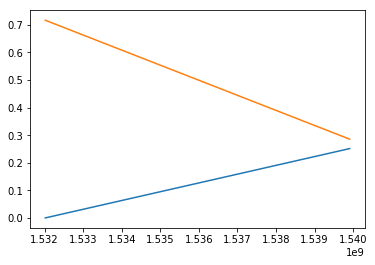

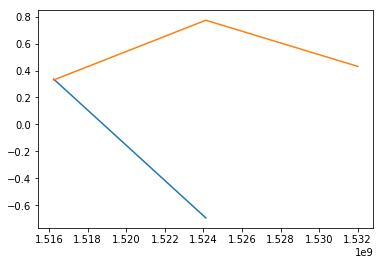

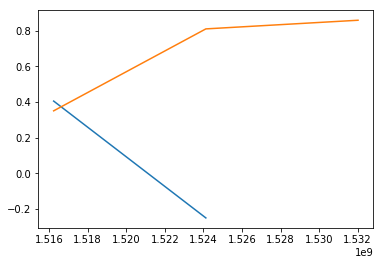

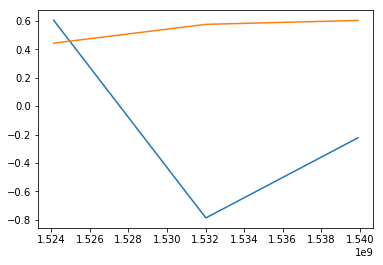

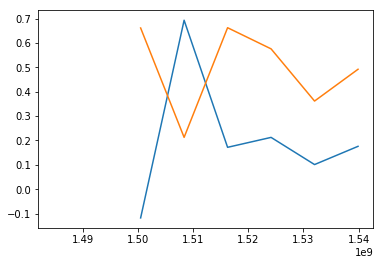

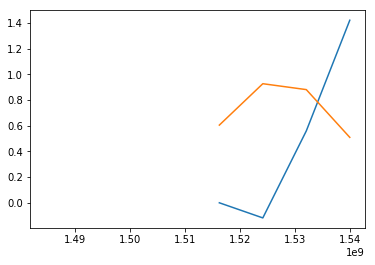

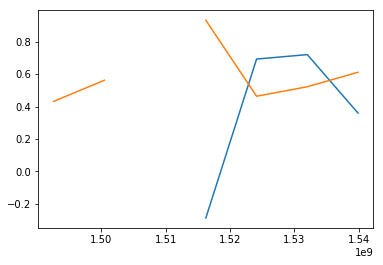

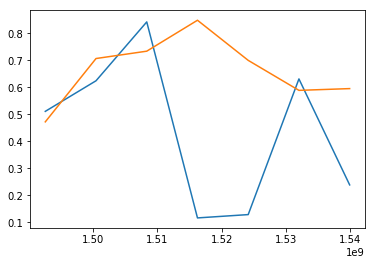

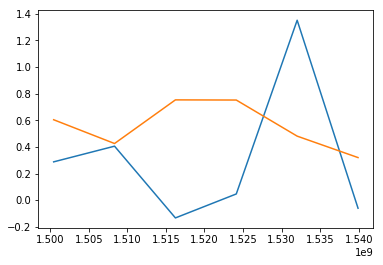

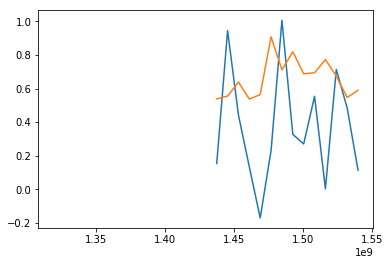

In [82]:
for i, row in dl_top_10_neg.iterrows(): 
    plt.plot(row['freq_diff_dict'].keys(), list(row['freq_diff_dict_log'].values()))
    plt.plot(row['d_u'].keys(), row['d_u'].values())    
    plt.show()

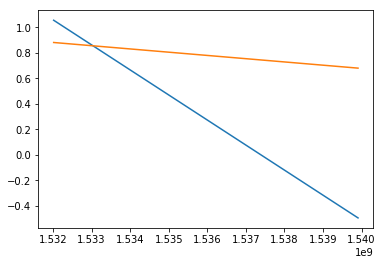

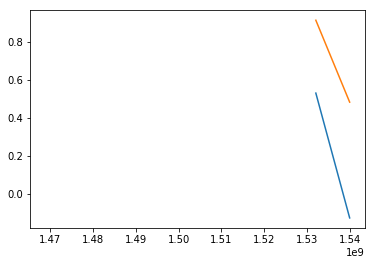

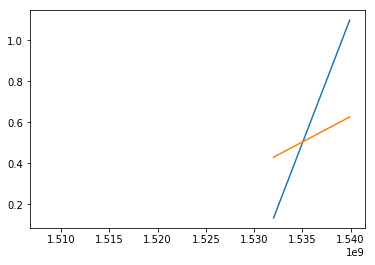

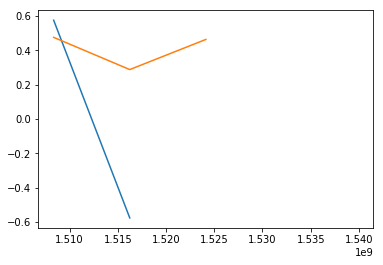

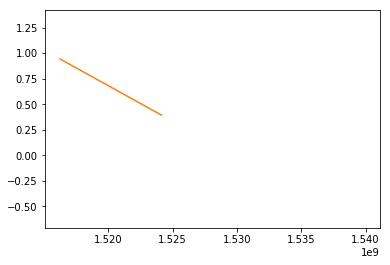

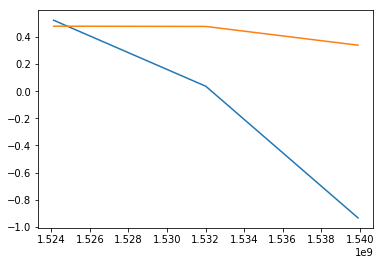

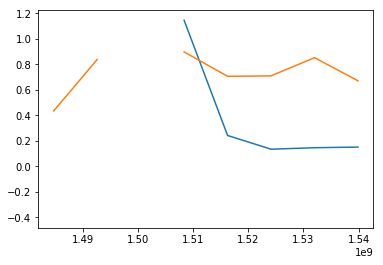

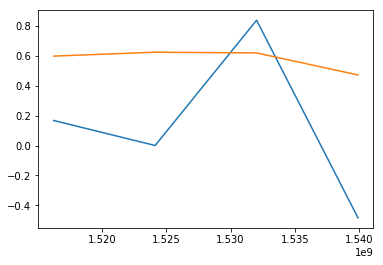

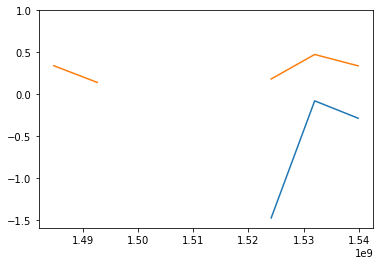

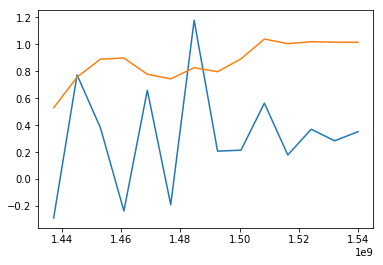

In [83]:
for i, row in dl_top_10_pos.iterrows(): 
    plt.plot(row['freq_diff_dict'].keys(), list(row['freq_diff_dict_log'].values()))
    plt.plot(row['d_u'].keys(), row['d_u'].values())    
    plt.show()

In [84]:
#highest correlations for d_u
display(full_df.sort_values(by='d_u_freq_diff').iloc[:10])
display(full_df.sort_values(by='d_u_freq_diff', ascending=False).iloc[:10])

word       category  \
5           ndris  cat_abbrev_pl   
12   vortioxetine       generics   
74     quetiapine       generics   
22   clomipramine       generics   
102       abilify    brand_names   
56       ketamine       generics   
76         buspar    brand_names   
5      sertraline       generics   
63        remeron    brand_names   
29     wellbutrin    brand_names   

                                                  freq  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 10, 1326898143: nan, 1334787372: ...   

                                                   d_s  \
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
12   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
74   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
22   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
102  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
56   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
76   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
63   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_p  \
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
12   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
74   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
22   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
102  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
56   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
76   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
63   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_l  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.04346929566805402, 1326898143: ...   

                                                   d_u  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {1319008914: nan, 1326898143: nan, 1334787372:...   
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
63   {1319008914: nan, 1326898143: nan, 1334787372:...   
29   {1319008914: 0.6436557927204237, 1326898143: n...   

                                                   d_t  \
5    {1319008914: nan, 1326898143: nan, 1334787372:...   
12   {1319008914: nan, 1326898143: nan, 1334787372:...   
74   {1319008914: nan, 1326898143: nan, 1334787372:...   
22   {1319008914: nan, 1326898143: nan, 1334787372:...   
102  {1319008914: nan, 1326898143: nan, 1334787372:...   
56   {1319008914: nan, 1326898143: nan, 1334787372:...   
76   {131900891

word       category  \
66            wort       generics   
51         lithium       generics   
104         latuda    brand_names   
14         fetzima    brand_names   
7       duloxetine       generics   
20   amitriptyline       generics   
1            snris  cat_abbrev_pl   
106       seroquel    brand_names   
58      tianeptine       generics   
95            same    brand_names   

                                                  freq  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                   d_s  \
66   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
51   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
104  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
14   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
7    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
20   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
106  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
58   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
95   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_p  \
66   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
51   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
104  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
14   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
7    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
20   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1    {1319008914: 0.0, 1326898143: nan, 1334787372:...   
106  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
58   {1319008914: 0.0, 1326898143: nan, 1334787372:...   
95   {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                   d_l  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                   d_u  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    {1319008914: nan, 1326898143: nan, 1334787372:...   
106  {1319008914: nan, 1326898143: nan, 1334787372:...   
58   {1319008914: nan, 1326898143: nan, 1334787372:...   
95   {1319008914: inf, 1326898143: nan, 1334787372:...   

                                                   d_t  \
66   {1319008914: nan, 1326898143: nan, 1334787372:...   
51   {1319008914: nan, 1326898143: nan, 1334787372:...   
104  {1319008914: nan, 1326898143: nan, 1334787372:...   
14   {1319008914: nan, 1326898143: nan, 1334787372:...   
7    {1319008914: nan, 1326898143: nan, 1334787372:...   
20   {1319008914: nan, 1326898143: nan, 1334787372:...   
1    

## Subset to generics and brand names and rerun: 

In [85]:
#gens_brands = full_df[(full_df['category'] == 'generics')|(full_df['category'] == 'brand_names')]
gens_brands = full_df[full_df['category'] != 'cat_no_abbrev']

display(gens_brands.shape)
display(gens_brands.head())

(213, 32)

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

             ...             rank_freq_diff rank_normed_freq_diff  \
0            ...                  -0.404496              0.620156   
1            ...                  -0.306038              0.039716   
2            ...                  -0.500790              0.204750   
3            ...                        NaN                   NaN   
4            ...                  -0.804735              0.796542   

  d_s_freq_diff_log d_p_freq_diff_log d_l_freq_diff_log d_t_freq_diff_log  \
0               NaN               NaN         -0.385311         -0.024323   
1               NaN               NaN         -0.481565          0.273590   
2               NaN               NaN         -0.487544          0.397322   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN          0.234539         -0.622272   

   d_u_freq_diff_log  freq_log_dict_freq_diff_log  rank_freq_diff_log  \
0           0.332543                    -0.830048           -0.628318   
1           0.670567                    -0.439468           -0.601724   
2           0.524893                    -0.702338           -0.820625   
3

In [86]:
def DisplayCorrs(df): 
    print("ds: ")
    display(df['d_s_freq_diff'].mean())
    display(df['d_s_freq_diff'].std())

    print("dp: ")
    display(df['d_p_freq_diff'].mean())
    display(df['d_p_freq_diff'].std())

    print("dl: ")
    display(df['d_l_freq_diff'].mean())
    display(df['d_l_freq_diff'].std())

    print("du: ")
    display(df['d_u_freq_diff'].mean())
    display(df['d_u_freq_diff'].std())
    

    print("dt: ")    
    display(df['d_t_freq_diff'].mean())
    display(df['d_t_freq_diff'].std())

In [87]:
display(gens_brands.shape)
DisplayCorrs(gens_brands)

(213, 32)

ds: 


0.1266611873703747

0.6579288799247993

dp: 


0.24370862640022972

nan

dl: 


-0.013778686403580665

0.5819172618096293

du: 


0.20836461832809433

0.5447682638596828

dt: 


0.2151645291475257

0.5697591264100943

In [88]:
gens = full_df[full_df['category'] == 'generics'] 
DisplayCorrs(gens)

ds: 


nan

nan

dp: 


nan

nan

dl: 


-0.05445510179418712

0.6467871505778863

du: 


0.2582755416119055

0.6560979818547953

dt: 


0.20066173519318195

0.6657201745723188

In [89]:
brand_names = full_df[full_df['category'] == 'brand_names'] 
DisplayCorrs(brand_names)

ds: 


0.75255676133486

nan

dp: 


nan

nan

dl: 


0.02001832713670585

0.5207964616612326

du: 


0.20192516927885756

0.43383837623912735

dt: 


0.26095271112442414

0.4706646720708646

In [90]:
cat_abbrev_s = full_df[full_df['category'] == 'cat_abbrev_sing'] 
DisplayCorrs(cat_abbrev_s)

ds: 


-0.02981270612074663

0.6433765246134355

dp: 


0.24370862640022972

nan

dl: 


-0.10835123492910106

0.616791290325736

du: 


0.2223525319713121

0.2618477863125858

dt: 


0.13268430643847226

0.5421456761574605

# Descriptive statistics: 

In [91]:
#generate list of variables for descriptive statistics
my_vars = [('d_u', 'D^U'), ('d_t', 'D^T'), ('d_l', 'D^L'), ('freq', 'Frequency')]

def DescStats(desc_df, desc_vars):
    rel_imp_df = pd.DataFrame(columns=[x[0] for x in desc_vars])
    for var in desc_vars:
        print("Variable:", var[0])
        desc_df[var[0] + '_list'] = desc_df[var[0]].map(lambda x: list(x.values()))
        for_hist = desc_df[var[0] + '_list'].tolist()
        for_hist = np.array([x for sublist in for_hist for x in sublist])
        for_hist = for_hist[np.isfinite(for_hist)]
        print("iqr\t", iqr(for_hist, nan_policy='omit'))
        
        display(pd.Series(for_hist).describe())
        sns.distplot(pd.Series(for_hist, name = '$' + var[1] + '$')).get_figure().savefig(var[0] + '_plot.png')
        rel_imp_df[var[0]] = for_hist
        
        plt.clf()
    return rel_imp_df

In [92]:
rel_imp = DescStats(gens_brands, my_vars)

Variable: d_u
iqr	 0.23689337590256626


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    388.000000
mean       0.599916
std        0.178099
min        0.111319
25%        0.484939
50%        0.603357
75%        0.721832
max        1.039211
dtype: float64

Variable: d_t
iqr	 0.1751733498628032


count    388.000000
mean       0.700560
std        0.143407
min        0.208983
25%        0.621383
50%        0.706471
75%        0.796556
max        0.983195
dtype: float64

Variable: d_l
iqr	 0.05566969797848598


count    388.000000
mean       0.048142
std        0.074196
min       -0.323845
25%        0.033809
50%        0.066039
75%        0.089479
max        0.156110
dtype: float64

Variable: freq
iqr	 45.0


count    388.000000
mean      55.226804
std       98.055488
min        6.000000
25%        9.000000
50%       19.000000
75%       54.000000
max      977.000000
dtype: float64

<Figure size 432x288 with 0 Axes>

In [93]:
display(rel_imp.head())

d_u       d_t       d_l  freq
0  0.503873  0.593534  0.063096   7.0
1  0.647921  0.631844  0.032401  10.0
2  0.502082  0.632493  0.088021  57.0
3  0.632585  0.736598 -0.004051  40.0
4  0.595055  0.648833  0.081848  54.0

# Make dataset for relative importance calculation: 

In [94]:
#combine across all time steps
rel_vars = ['d_s', 'd_l', 'freq', 'd_p', 'd_u', 'd_t', 'freq_diff_dict_log', 'freq_log_dict']
rel_imp_df = gens_brands.copy()

for var in rel_vars: 
    rel_imp_df["sum_" + var] = rel_imp_df[var].map(lambda x: [y for y in list(x.values())])

display(rel_imp_df.head())

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
3   fluvoxamine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
3  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
3  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                           
4                        ...                           

                                            d_l_list  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                           freq_list  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                             sum_d_s  \
0  [0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [95]:
#clean up to prepare to output to csv
rel_imp_df = rel_imp_df[['sum_freq_log_dict', 'sum_freq_diff_dict_log', 'sum_d_u', 'sum_d_t', 'sum_d_l']]

final_df = pd.DataFrame()
#subset to complete cases: 
for col in rel_imp_df.columns: 
    final_df[col] = list(itertools.chain.from_iterable(rel_imp_df[col].tolist()))
    
final_df = final_df.dropna()

display(final_df.head())
display(final_df.shape)

final_df.to_csv('final_df.csv')

sum_freq_log_dict  sum_freq_diff_dict_log   sum_d_u   sum_d_t   sum_d_l
21           2.302585                1.740466  0.647921  0.631844  0.032401
22           4.043051               -0.354172  0.502082  0.632493  0.088021
23           3.688879                0.300105  0.632585  0.736598 -0.004051
24           3.988984               -0.160343  0.595055  0.648833  0.081848
25           3.828641                0.693147  0.488765  0.794756  0.103463

(325, 5)

In [96]:
#print words for appendix: 
print(gens_brands['word'].tolist())

['citalopram', 'escitalopram', 'fluoxetine', 'fluvoxamine', 'paroxetine', 'sertraline', 'desvenlafaxine', 'duloxetine', 'levomilnacipran', 'milnacipran', 'venlafaxine', 'vilazodone', 'vortioxetine', 'nefazodone', 'trazodone', 'atomoxetine', 'reboxetine', 'teniloxazine', 'viloxazine', 'bupropion', 'amitriptyline', 'amitriptylinoxide', 'clomipramine', 'desipramine', 'dibenzepin', 'dimetacrine', 'dosulepin', 'doxepin', 'imipramine', 'lofepramine', 'melitracen', 'nitroxazepine', 'nortriptyline', 'noxiptiline', 'opipramol', 'pipofezine', 'protriptyline', 'trimipramine', 'amoxapine', 'maprotiline', 'mianserin', 'mirtazapine', 'setiptiline', 'bifemelane', 'selegiline', 'metralindole', 'moclobemide', 'pirlindole', 'toloxatone', 'eprobemide', 'buspirone', 'lithium', 'thyroxine', 'triiodothyronine', 'agomelatine', 'esketamine', 'ketamine', 'tandospirone', 'tianeptine', 'agent', 'ethyltryptamine', 'indeloxazine', 'medifoxamine', 'oxaflozane', 'pivagabine', 'methionine', 'wort', 'hydroxytryptophan

# Predictive modeling: 

## Format results for logistic regression: 

In [98]:
#pickle gens_brands so you don't have to keep rerunning code above
#gens_brands.to_pickle('gens_brands.pkl')
gens_brands = pd.read_pickle('gens_brands.pkl')
display(gens_brands.shape)

(213, 36)

In [100]:
#test for an individual dataset
start = -9
end = -1
test = gens_brands['d_l'].apply(pd.Series).add_prefix('d_l' + '_')

#impute missing values with mean
test = test.fillna(test.mean())
test = test[test.columns[start:end]].copy()

display(test.head())

d_l_1476793494  d_l_1484682723  d_l_1492571952  d_l_1500461181  \
0        0.063096        0.005893        0.032401        0.088021   
1        0.046042        0.005893        0.031374        0.075986   
2        0.046042       -0.204952        0.031374        0.042548   
3        0.046042        0.005893        0.031374        0.040446   
4        0.046042        0.005893        0.031374        0.040446   

   d_l_1508350410  d_l_1516239639  d_l_1524128868  d_l_1532018097  
0       -0.004051        0.081848        0.103463        0.102048  
1        0.064526        0.108698        0.051174        0.104187  
2        0.066168        0.122751        0.120726        0.129507  
3        0.051204        0.075629        0.063469        0.074796  
4        0.051204        0.097487        0.105803        0.087334

In [101]:
def FeatureSet(expand, start, end): 
    df_list = []

    for var in expand: 
        cur = gens_brands[var].apply(pd.Series).add_prefix(var + '_')
        
        #fill inf values with nan, and then fill na
        cur = cur.replace([np.inf, -np.inf], np.nan)
        cur = cur.fillna(cur.mean())
        
        cur = cur[cur.columns[start:end]].copy()
        df_list.append(cur)

    expanded = pd.concat(df_list, axis=1)
    return expanded

In [102]:
#feature sets: frequency only, frequency + d_l, frequency + d_t + d_u, frequency + d_l + d_t + d_u
var_lists = [['freq_log_dict'], ['freq_log_dict', 'd_l'], ['freq_log_dict', 'd_u', 'd_t'], ['freq_log_dict', 'd_l', 'd_u', 'd_t']]
#var_lists = [['freq_log_dict'], ['d_l'], ['d_u', 'd_t'], ['d_l', 'd_u', 'd_t']]

feature_sets = []
for var_list in var_lists: 
    feature_set = FeatureSet(var_list, -9, -1)
    display(feature_set.head())
    feature_sets.append(feature_set)

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  
0                  3.828641                  4.521789  
1                  3.583519                  4.343805  
2                  4.356709                  3.871201  
3                  3.398010                  1.791759  
4                  3.135494                  3.401197

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723  d_l_1492571952  d_l_1500461181  d_l_1508350410  \
0        0.005893        0.032401        0.088021       -0.004051   
1        0.005893        0.031374        0.075986        0.064526   
2       -0.204952        0.031374        0.042548        0.066168   
3        0.005893        0.031374        0.040446        0.051204   
4        0.005893        0.031374        0.040446        0.051204   

   d_l_1516239639  d_l_1524128868  d_l_1532018097  
0        0.081848        0.103463        0.102048  
1        0.108698        0.051174        0.104187  
2        0.122751        0.120726        0.129507  
3        0.075629        0.063469        0.074796  
4        0.097487        0.105803        0.087334

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_u_1476793494  \
0                  3.828641                  4.521789        0.503873   
1                  3.583519                  4.343805        0.565381   
2                  4.356709                  3.871201        0.565381   
3                  3.398010                  1.791759        0.565381   
4                  3.135494                  3.401197        0.565381   

   d_u_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.546350       ...              0.488765        0.634133   
1        0.546350       ...              0.770832        0.564652   
2        0.495113       ...              0.575387        0.591552   
3        0.546350       ...              0.579000        0.666162   
4        0.546350       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 24 columns]

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.005893       ...              0.488765        0.634133   
1        0.005893       ...              0.770832        0.564652   
2       -0.204952       ...              0.575387        0.591552   
3        0.005893       ...              0.579000        0.666162   
4        0.005893       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 32 columns]

In [103]:
# #preliminaries
# data = expanded.copy()

# #train-test split
# display(data.head())
# y = data.pop('label')
# X = data

# display(X.head())

# #get number of processors
# cpus = multiprocessing.cpu_count()

In [104]:
# print(X.shape)
# print(y.shape)

In [105]:
def MakeLabels(in_df, start, end, response): 
        labels = in_df[response].map(lambda x: (x[end] - x[start]) > 0)
        display(labels.value_counts())
        return labels
    #for each word in the in_df, lambda x: calculate freq_dict_log[end] - freq_dict_log[start]
    #if it's negative, word declined in frequency
    #if it's positive, word increased in frequency 

In [106]:
test_y = MakeLabels(gens_brands, 1508350410, 1539907326, 'freq_log_dict')

False    182
True      31
Name: freq_log_dict, dtype: int64

In [107]:
y = MakeLabels(gens_brands, 1532018097, 1539907326, 'freq_log_dict')

False    176
True      37
Name: freq_log_dict, dtype: int64

In [108]:
display(gens_brands['rank'].head())

0    {1319008914: nan, 1326898143: nan, 1334787372:...
1    {1319008914: nan, 1326898143: nan, 1334787372:...
2    {1319008914: nan, 1326898143: nan, 1334787372:...
3    {1319008914: nan, 1326898143: nan, 1334787372:...
4    {1319008914: nan, 1326898143: nan, 1334787372:...
Name: rank, dtype: object

In [110]:
test_y_rank = MakeLabels(gens_brands, 1532018097, 1539907326, 'rank_normed')

False    197
True      16
Name: rank_normed, dtype: int64

## Fit and evaluate models with different feature sets: 

In [113]:
#fit logistic regression with cross-validation and print report: 
def LogisticEval(my_X, my_y): 
    #fit and predict
    logreg = LogisticRegression()
    pred = model_selection.cross_val_predict(logreg, my_X, my_y, n_jobs=-1, cv=10)
    print(metrics.accuracy_score(my_y, pred))
    print(metrics.classification_report(my_y, pred))

In [114]:
#with the baseline frequency-only feature set: 
for X in feature_sets: 
    display(X.head())
    LogisticEval(X, y)

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  
0                  3.828641                  4.521789  
1                  3.583519                  4.343805  
2                  4.356709                  3.871201  
3                  3.398010                  1.791759  
4                  3.135494                  3.401197

0.8450704225352113
              precision    recall  f1-score   support

       False       0.85      0.99      0.91       176
        True       0.83      0.14      0.23        37

   micro avg       0.85      0.85      0.85       213
   macro avg       0.84      0.56      0.57       213
weighted avg       0.84      0.85      0.80       213



freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723  d_l_1492571952  d_l_1500461181  d_l_1508350410  \
0        0.005893        0.032401        0.088021       -0.004051   
1        0.005893        0.031374        0.075986        0.064526   
2       -0.204952        0.031374        0.042548        0.066168   
3        0.005893        0.031374        0.040446        0.051204   
4        0.005893        0.031374        0.040446        0.051204   

   d_l_1516239639  d_l_1524128868  d_l_1532018097  
0        0.081848        0.103463        0.102048  
1        0.108698        0.051174        0.104187  
2        0.122751        0.120726        0.129507  
3        0.075629        0.063469        0.074796  
4        0.097487        0.105803        0.087334

0.8403755868544601
              precision    recall  f1-score   support

       False       0.84      0.99      0.91       176
        True       0.80      0.11      0.19        37

   micro avg       0.84      0.84      0.84       213
   macro avg       0.82      0.55      0.55       213
weighted avg       0.83      0.84      0.79       213



freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_u_1476793494  \
0                  3.828641                  4.521789        0.503873   
1                  3.583519                  4.343805        0.565381   
2                  4.356709                  3.871201        0.565381   
3                  3.398010                  1.791759        0.565381   
4                  3.135494                  3.401197        0.565381   

   d_u_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.546350       ...              0.488765        0.634133   
1        0.546350       ...              0.770832        0.564652   
2        0.495113       ...              0.575387        0.591552   
3        0.546350       ...              0.579000        0.666162   
4        0.546350       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 24 columns]

0.8450704225352113
              precision    recall  f1-score   support

       False       0.84      1.00      0.91       176
        True       1.00      0.11      0.20        37

   micro avg       0.85      0.85      0.85       213
   macro avg       0.92      0.55      0.55       213
weighted avg       0.87      0.85      0.79       213



freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.005893       ...              0.488765        0.634133   
1        0.005893       ...              0.770832        0.564652   
2       -0.204952       ...              0.575387        0.591552   
3        0.005893       ...              0.579000        0.666162   
4        0.005893       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 32 columns]

0.8450704225352113
              precision    recall  f1-score   support

       False       0.84      1.00      0.91       176
        True       1.00      0.11      0.20        37

   micro avg       0.85      0.85      0.85       213
   macro avg       0.92      0.55      0.55       213
weighted avg       0.87      0.85      0.79       213



In [115]:
#fit logistic regression with cross-validation and print report: 
def SVMEval(my_X, my_y): 
    #fit and predict
    svm = sklearn.svm.SVC().fit(my_X, my_y)
    pred = model_selection.cross_val_predict(svm, my_X, my_y, n_jobs=-1, cv=10)
    print(metrics.accuracy_score(my_y, pred))
    print(metrics.classification_report(my_y, pred))

In [116]:
#with the baseline frequency-only feature set: 
for X in feature_sets: 
    display(X.head())
    SVMEval(X, y)

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  
0                  3.828641                  4.521789  
1                  3.583519                  4.343805  
2                  4.356709                  3.871201  
3                  3.398010                  1.791759  
4                  3.135494                  3.401197

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8873239436619719
              precision    recall  f1-score   support

       False       0.90      0.97      0.93       176
        True       0.76      0.51      0.61        37

   micro avg       0.89      0.89      0.89       213
   macro avg       0.83      0.74      0.77       213
weighted avg       0.88      0.89      0.88       213



freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723  d_l_1492571952  d_l_1500461181  d_l_1508350410  \
0        0.005893        0.032401        0.088021       -0.004051   
1        0.005893        0.031374        0.075986        0.064526   
2       -0.204952        0.031374        0.042548        0.066168   
3        0.005893        0.031374        0.040446        0.051204   
4        0.005893        0.031374        0.040446        0.051204   

   d_l_1516239639  d_l_1524128868  d_l_1532018097  
0        0.081848        0.103463        0.102048  
1        0.108698        0.051174        0.104187  
2        0.122751        0.120726        0.129507  
3        0.075629        0.063469        0.074796  
4        0.097487        0.105803        0.087334

0.9061032863849765
              precision    recall  f1-score   support

       False       0.90      1.00      0.95       176
        True       1.00      0.46      0.63        37

   micro avg       0.91      0.91      0.91       213
   macro avg       0.95      0.73      0.79       213
weighted avg       0.92      0.91      0.89       213



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_u_1476793494  \
0                  3.828641                  4.521789        0.503873   
1                  3.583519                  4.343805        0.565381   
2                  4.356709                  3.871201        0.565381   
3                  3.398010                  1.791759        0.565381   
4                  3.135494                  3.401197        0.565381   

   d_u_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.546350       ...              0.488765        0.634133   
1        0.546350       ...              0.770832        0.564652   
2        0.495113       ...              0.575387        0.591552   
3        0.546350       ...              0.579000        0.666162   
4        0.546350       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 24 columns]

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8826291079812206
              precision    recall  f1-score   support

       False       0.88      1.00      0.93       176
        True       1.00      0.32      0.49        37

   micro avg       0.88      0.88      0.88       213
   macro avg       0.94      0.66      0.71       213
weighted avg       0.90      0.88      0.86       213



freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  d_l_1476793494  \
0                  3.828641                  4.521789        0.063096   
1                  3.583519                  4.343805        0.046042   
2                  4.356709                  3.871201        0.046042   
3                  3.398010                  1.791759        0.046042   
4                  3.135494                  3.401197        0.046042   

   d_l_1484682723       ...        d_u_1524128868  d_u_1532018097  \
0        0.005893       ...              0.488765        0.634133   
1        0.005893       ...              0.770832        0.564652   
2       -0.204952       ...              0.575387        0.591552   
3        0.005893       ...              0.579000        0.666162   
4        0.005893       ...              0.396516        0.361272   

   d_t_1476793494  d_t_1484682723  d_t_1492571952  d_t_1500461181  \
0        0.593534        0.713887        0.631844        0.632493   
1        0.667356        0.713887        0.700531        0.695940   
2        0.667356        0.860643        0.700531        0.842035   
3        0.667356        0.713887        0.700531        0.685004   
4        0.667356        0.713887        0.700531        0.685004   

   d_t_1508350410  d_t_1516239639  d_t_1524128868  d_t_1532018097  
0        0.736598        0.648833        0.794756        0.724150  
1        0.793858        0.794509        0.872361        0.792285  
2        0.625680        0.786661        0.737461        0.604664  
3        0.669220        0.731313        0.727114        0.651624  
4        0.669220        0.591111        0.761225        0.891759  

[5 rows x 32 columns]

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8732394366197183
              precision    recall  f1-score   support

       False       0.87      1.00      0.93       176
        True       1.00      0.27      0.43        37

   micro avg       0.87      0.87      0.87       213
   macro avg       0.93      0.64      0.68       213
weighted avg       0.89      0.87      0.84       213



# Regression models: 

In [143]:
#make labels
def MakeVals(in_df, start, end, response): 
    #take in whole dataset and copy it
    df = in_df.copy()
    
    #calculate difference
    df['vals'] = in_df[response].map(lambda x: (x[end] - x[start]))
    df['finite'] = df['vals'].map(lambda x: np.isfinite(x))
    display(df['finite'].value_counts())
    
    #drop rows with nan or inf labels
    df = df[df['finite'] == True]
    display(df.head())
    
    #pop column from copied df
    df_y = df.pop('vals')
    display(df_y.head())
    df_X = df.drop(columns=['finite'])
    display(df_X.head())
    
    #return tuple of (X, y)
    return (df_X, df_y)


In [144]:
y_vals = MakeVals(gens_brands, 1532018097, 1539907326, 'freq_log_dict')

False    165
True      48
Name: finite, dtype: int64

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
5    sertraline  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed   ...    \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   ...     
1  {1319008914: nan, 1326898143: nan, 1334787372:...   ...     
2  {1319008914: nan, 1326898143: nan, 1334787372:...   ...     
4  {1319008914: nan, 1326898143: nan, 1334787372:...   ...     
5  {1319008914: nan, 1326898143: nan, 1334787372:...   ...     

  d_u_freq_diff_log freq_log_dict_freq_diff_log rank_freq_diff_log  \
0          0.332543                   -0.830048          -0.628318   
1          0.670567                   -0.439468          -0.601724   
2          0.524893                   -0.702338          -0.820625   
4          0.526064                   -0.820841          -0.868001   
5         -0.237136                   -0.524203          -0.525281   

  rank_normed_freq_diff_log  \
0                  0.906039   
1                  0.369352   
2                  0.630280   
4                  0.857825   
5                  0.432267   

                                            d_u_list  \
0  [nan, nan, inf, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
5  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                            d_t_list  \
0  [nan, nan, inf, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, n

0    0.169559
1   -0.300754
2    0.117783
4   -0.223144
5    0.631015
Name: vals, dtype: float64

word  category                                               freq  \
0    citalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  escitalopram  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
2    fluoxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
4    paroxetine  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   
5    sertraline  generics  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_s  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_p  \
0  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
1  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
2  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
4  {1319008914: 0.0, 1326898143: nan, 1334787372:...   
5  {1319008914: 0.0, 1326898143: nan, 1334787372:...   

                                                 d_l  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_u  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                 d_t  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                                rank  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                                         rank_normed  \
0  {1319008914: nan, 1326898143: nan, 1334787372:...   
1  {1319008914: nan, 1326898143: nan, 1334787372:...   
2  {1319008914: nan, 1326898143: nan, 1334787372:...   
4  {1319008914: nan, 1326898143: nan, 1334787372:...   
5  {1319008914: nan, 1326898143: nan, 1334787372:...   

                         ...                         d_l_freq_diff_log  \
0                        ...                                 -0.385311   
1                        ...                                 -0.481565   
2                        ...                                 -0.487544   
4                        ...                                  0.234539   
5                        ...                                 -0.207719   

  d_t_freq_diff_log d_u_freq_diff_log freq_log_dict_freq_diff_log  \
0         -0.024323          0.332543                   -0.830048   
1          0.273590          0.670567                   -0.439468   
2          0.397322          0.524893                   -0.702338   
4         -0.622272          0.526064                   -0.820841   
5          0.481720         -0.237136                   -0.524203   

  rank_freq_diff_log rank_normed_freq_diff_log  \
0          -0.628318                  0.906039   
1          -0.601724                  0.369352   
2          -0.820625                  0.630280   
4          -0.868001                  0.857825   
5          -0.525281                  0.432267   

          

In [134]:
display(y_vals)

0      0.169559
1     -0.300754
2      0.117783
3           NaN
4     -0.223144
5      0.631015
6           NaN
7           NaN
8           NaN
9           NaN
10     0.620388
11          NaN
12          NaN
13          NaN
14    -0.358945
15          NaN
16          NaN
17          NaN
18          NaN
19     0.868241
20     0.036368
21          NaN
22    -0.788457
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
103    0.174353
104    0.133531
105         NaN
106    0.836248
107         NaN
108         NaN
109         NaN
110         NaN
111         NaN
112         NaN
113         NaN
114         NaN
0      0.188836
1      0.145182
2           NaN
3           NaN
4           NaN
5      0.000000
6     -0.117783
7           NaN
8      1.098612
0      0.260912
1      0.885519
2           NaN
3           NaN
4      0.000000
5      0.998529
6           NaN
7           NaN
8           NaN
Name: freq_log_dict, Len

In [132]:
#start with lasso regression
def LassoEval(my_X, my_y): 
    #fit and predict
    lasso = LassoCV(cv=10, n_jobs=-1).fit(my_X, my_y)
    
    #evaluate using R^2
    score = lasso.score()
    print(score)

In [133]:
for X in feature_sets: 
    display(X.head())
    LassoEval(X, y_vals)

freq_log_dict_1476793494  freq_log_dict_1484682723  \
0                  1.945910                  2.575448   
1                  2.777279                  2.575448   
2                  2.777279                  2.302585   
3                  2.777279                  2.575448   
4                  2.777279                  2.575448   

   freq_log_dict_1492571952  freq_log_dict_1500461181  \
0                  2.302585                  4.043051   
1                  3.166137                  2.484907   
2                  3.166137                  2.397895   
3                  3.166137                  3.191523   
4                  3.166137                  3.191523   

   freq_log_dict_1508350410  freq_log_dict_1516239639  \
0                  3.688879                  3.988984   
1                  2.890372                  3.091042   
2                  3.135494                  3.555348   
3                  3.196128                  3.490797   
4                  3.196128                  2.890372   

   freq_log_dict_1524128868  freq_log_dict_1532018097  
0                  3.828641                  4.521789  
1                  3.583519                  4.343805  
2                  4.356709                  3.871201  
3                  3.398010                  1.791759  
4                  3.135494                  3.401197

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').